In [1]:
import torch.nn as nn_lib
import torch as torch_lib
import torch.nn.functional as func_lib
from tqdm import tqdm as progress_lib
import os as os_lib
import numpy as np_lib
import matplotlib.pyplot as plot_lib
import requests as requests_lib
import torch.optim as optim_lib
from tqdm import tqdm as progress_lib

image_data.shape: (106, 100, 100, 3)
pose_data.shape: (106, 4, 4)
focal_length: 138.88887889922103


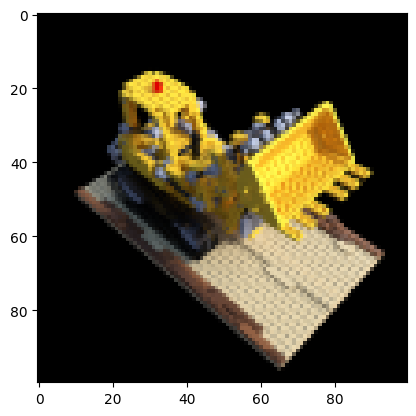

In [2]:
# Define the URL and the local filename for the dataset
dataset_url = 'http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz'
dataset_filename = 'tiny_nerf_data.npz'

# Download the dataset if it does not exist locally
if not os_lib.path.exists(dataset_filename):
    response = requests_lib.get(dataset_url)
    with open(dataset_filename, 'wb') as dataset_file:
        dataset_file.write(response.content)

# Set the device to GPU if available, otherwise use CPU
computation_device = torch_lib.device("cuda" if torch_lib.cuda.is_available() else "cpu")

# Set random seeds for reproducibility
torch_lib.manual_seed(888)
np_lib.random.seed(555)
torch_lib.backends.cudnn.benchmark = True

# Load the dataset
data = np_lib.load(dataset_filename)
image_data = data['images']
pose_data = data['poses']
focal_length = data['focal']
height, width = image_data.shape[1:3]

# Print dataset information
print("image_data.shape:", image_data.shape)
print("pose_data.shape:", pose_data.shape)
print("focal_length:", focal_length)

# Number of training images
num_training_images = 100

# Separate test image and pose from the dataset
test_image, test_pose = image_data[101], pose_data[101]
image_data = image_data[:num_training_images]
pose_data = pose_data[:num_training_images]

# Display the test image
plot_lib.imshow(test_image)
plot_lib.show()


In [3]:


# Define the NeRF class
class NeuralRadianceField(nn_lib.Module):
    def __init__(self,view_input_channels=24, directions_use_view=True, depth=8, width=256, input_channels=60):
        super(NeuralRadianceField, self).__init__()
        # Example assert statements
        assert isinstance(depth, int), "Depth must be an integer"
        self.depth = depth
        assert isinstance(width, int), "Width must be an integer"
        self.width = width
        assert isinstance(input_channels, int), "Input channels must be an integer"
        self.input_channels = input_channels
        assert isinstance(view_input_channels, int), "View input channels must be an integer"
        self.directions_use_view = directions_use_view
        assert isinstance(directions_use_view, bool), "Directions use view must be a boolean"

        self.nnetwork = nn_lib.ModuleList([nn_lib.Linear(input_channels, width)])
        self.nnetwork.append(nn_lib.Linear(width, width))
        self.nnetwork.append(nn_lib.Linear(width, width))
        self.nnetwork.append(nn_lib.Linear(width, width))
        self.nnetwork.append(nn_lib.Linear(width, width))
        self.nnetwork.append(nn_lib.Linear(width + input_channels, width))
        self.nnetwork.append(nn_lib.Linear(width, width))
        self.nnetwork.append(nn_lib.Linear(width, width))
        self.nnetwork.append(nn_lib.Linear(width, width))

        self.alpha_layer = nn_lib.Linear(width, 1)
        self.layer_feature = nn_lib.Linear(width, width)

        width_out = width // 2
        if directions_use_view:
            self.directional_projection = nn_lib.Linear(width + view_input_channels, width_out)
        else:
            self.directional_projection = nn_lib.Linear(width, width_out)
        self.rgb_layer = nn_lib.Linear(width_out, 3)


    def forward(self, points_input, views_input):
        hidden_rep = torch_lib.empty_like(points_input).copy_(points_input).detach()

        hidden_rep = func_lib.relu(self.nnetwork[0](hidden_rep))
        hidden_rep = func_lib.relu(self.nnetwork[1](hidden_rep))
        hidden_rep = func_lib.relu(self.nnetwork[2](hidden_rep))
        hidden_rep = func_lib.relu(self.nnetwork[3](hidden_rep))
        hidden_rep = func_lib.relu(self.nnetwork[4](hidden_rep))
        hidden_rep = torch_lib.cat((points_input, hidden_rep), -1)
        hidden_rep = func_lib.relu(self.nnetwork[5](hidden_rep))
        hidden_rep = func_lib.relu(self.nnetwork[6](hidden_rep))
        hidden_rep = func_lib.relu(self.nnetwork[7](hidden_rep))

        feature_output = self.layer_feature(hidden_rep)
        alpha_output = func_lib.relu(self.alpha_layer(hidden_rep))

        if self.directions_use_view and views_input is not None:
            hidden_rep = torch_lib.cat((feature_output, views_input), -1)

        hidden_rep = self.directional_projection(hidden_rep)
        hidden_rep = func_lib.relu(hidden_rep)

        rgb_output = self.rgb_layer(hidden_rep)
        rgb_output = torch_lib.sigmoid(rgb_output)

        return rgb_output, alpha_output

In [4]:

def positional_encoding(input_x, num_levels):
    # Create a frequency matrix
    frequency_bands = 2.0 ** torch_lib.arange(num_levels, dtype=input_x.dtype, device=input_x.device)

    # Reshape input and frequencies for broadcasting
    input_expanded = input_x.unsqueeze(-1) * frequency_bands.unsqueeze(0)

    # Apply sine and cosine to the frequency-transformed inputs
    sin_encodings = torch_lib.sin(input_expanded)
    cos_encodings = torch_lib.cos(input_expanded)

    # Concatenate the results
    pos_encoding = torch_lib.cat([sin_encodings, cos_encodings], dim=-1)

    return pos_encoding.reshape(input_x.shape[0], -1)


def sample_rays_numpy(height, width, focal_length, camera_to_world):
    # Create a grid of coordinates corresponding to pixel centers
    pixel_i, pixel_j = np_lib.mgrid[0:height, 0:width].astype(np_lib.float32)

    # Stack to create a (height, width, 2) array
    pixel_centers = np_lib.stack([pixel_i, pixel_j], axis=-1)

    # Adjust pixel centers to be centered around (0,0) and scaled by focal length
    directions = np_lib.empty((height, width, 3), dtype=np_lib.float32)
    directions[..., 0] = (pixel_centers[..., 1] - width * 0.5 + 0.5) / focal_length
    directions[..., 1] = -(pixel_centers[..., 0] - height * 0.5 + 0.5) / focal_length
    directions[..., 2] = -1.0  # All directions point forward in camera space

    # Apply the camera to world transformation to get the ray directions in world space
    ray_directions = directions @ camera_to_world[:3, :3].T
    ray_origins = np_lib.tile(camera_to_world[:3, 3], (height, width, 1))

    return ray_origins, ray_directions


def uniform_sample_points(start, end, num_samples, device):
    # Create evenly spaced points in the range [0, 1)
    base_points = torch_lib.linspace(0.0, 1.0, num_samples, device=device)

    # Add random jitter to each point
    jitter = torch_lib.rand(num_samples, device=device) / num_samples

    # Shift base points by the random jitter
    sampled_points = base_points + jitter

    # Scale to the desired range [start, end)
    scaled_points = start + (end - start) * sampled_points

    return scaled_points



In [5]:

import torch as T
import torch.nn.functional as F


def get_rgb_weights(model, samples, directions, z_vals, device, noise_std=0.0, use_viewdirs=False):
    # Encode the sample points
    samples_flat = samples.view(-1, 3)
    encoded_samples = positional_encoding(samples_flat, num_levels=10)

    # Optionally encode the ray directions
    if use_viewdirs:
        expanded_dirs = directions.unsqueeze(1).expand_as(samples).reshape(-1, 3)
        normalized_dirs = F.normalize(expanded_dirs, dim=-1)
        encoded_dirs = positional_encoding(normalized_dirs, num_levels=4)
    else:
        encoded_dirs = None

    # Get RGB and density (sigma) from the network
    rgb, sigma = model(encoded_samples, encoded_dirs)
    rgb = rgb.view(*samples.shape[:-1], 3)
    sigma = sigma.view(*samples.shape[:-1])

    # Compute distances between consecutive z-values
    deltas = - z_vals[..., :-1] + z_vals[..., 1:]
    deltas = T.cat([deltas, T.full((deltas.shape[0], 1), 1e10, device=device)], dim=-1)
    ray_norms = T.norm(directions, dim=-1, keepdim=True)
    deltas *= ray_norms

    # Add noise to density if specified
    if noise_std > 0.0:
        noise = T.randn(sigma.shape, device=device) * noise_std
        sigma += noise

    # Compute alpha values and weights
    alpha = 1.0 - T.exp(-sigma * deltas)
    transmittance = T.cumprod(T.cat([T.ones((alpha.shape[0], 1), device=device), 1.0 - alpha + 1e-10], dim=-1), dim=-1)
    weights = alpha * transmittance[:, :-1]

    return rgb, weights



def rendering(model, ray_bundle, bounds, num_samples, comp_device, noise_std=0.0, directions_use_view=False):
    origins, directions = ray_bundle
    near, far = bounds
    uniform_samples, importance_samples = num_samples

    # Generate uniform depth samples
    z_vals = T.linspace(near, far, uniform_samples, device=comp_device).expand(origins.shape[0], uniform_samples)
    points = origins.unsqueeze(1) + directions.unsqueeze(1) * z_vals.unsqueeze(-1)


    if importance_samples is not None:
        with T.no_grad():
            initial_rgb, initial_weights = get_rgb_weights(model, points, directions, z_vals, comp_device, noise_std, directions_use_view)
            mid_z_vals = 0.5 * (z_vals[..., :-1] + z_vals[..., 1:])
            importance_z_vals = pdf_sample_points(mid_z_vals, initial_weights[..., 1:-1], importance_samples, comp_device)


        combined_z_vals = T.cat([z_vals, importance_z_vals], dim=-1)
        combined_z_vals, _ = T.sort(combined_z_vals, dim=-1)
        expanded_points = origins.unsqueeze(1) + directions.unsqueeze(1) * combined_z_vals.unsqueeze(-1)
    else:
        combined_z_vals = z_vals
        expanded_points = points

    # Compute final RGB and weights
    final_rgb, final_weights = get_rgb_weights(model, expanded_points, directions, combined_z_vals, comp_device, noise_std, directions_use_view)

    # Compute final outputs
    color_map = T.sum(final_weights.unsqueeze(-1) * final_rgb, dim=-2)
    depth_map = T.sum(final_weights * combined_z_vals, dim=-1)
    acc_map = T.sum(final_weights, dim=-1)

    return color_map, depth_map, acc_map



def pdf_sample_points(mid_vals, weights, num_samples, device):
    # Normalize the weights to form the PDF
    weights_sum = weights.sum(dim=-1, keepdim=True)
    epsilon = 1e-8  # small value to avoid division by zero
    pdf = weights / (weights_sum + epsilon)

    # Calculate the CDF from the PDF
    cdf = T.cumsum(pdf, dim=-1)
    cdf = T.cat((T.zeros_like(cdf[..., :1]), cdf), dim=-1)

    # Draw uniform random samples
    uniform_samples = T.rand(*cdf.shape[:-1], num_samples, device=device)

    # Find indices in the CDF for the uniform samples
    bin_indices = T.searchsorted(cdf, uniform_samples, right=True)
    lower_idx = T.clamp(bin_indices - 1, min=0)
    upper_idx = T.clamp(bin_indices, max=cdf.shape[-1] - 1)

    # Gather values from bin_edges based on the CDF indices
    cdf_values_lower = T.gather(cdf, 1, lower_idx)
    cdf_values_upper = T.gather(cdf, 1, upper_idx)
    bin_values_lower = T.gather(mid_vals, 1, lower_idx)
    bin_values_upper = T.gather(mid_vals, 1, upper_idx)

    # Calculate the differences and interpolation factors
    delta_cdf = cdf_values_upper - cdf_values_lower
    delta_cdf = T.where(delta_cdf < epsilon, T.ones_like(delta_cdf) * epsilon, delta_cdf)
    interpolation_factors = (uniform_samples - cdf_values_lower) / delta_cdf

    # Ensure that the interpolation factors do not produce NaNs
    interpolation_factors = T.clamp(interpolation_factors, 0.0, 1.0)

    samples = bin_values_lower + interpolation_factors * (bin_values_upper - bin_values_lower)

    return samples

The number of batches is 488 and each batch has 2048 rays


100%|██████████| 488/488 [02:20<00:00,  3.47it/s]


PSNR score=tensor([21.6502])
Average loss per epoch = 0.023266172530816594


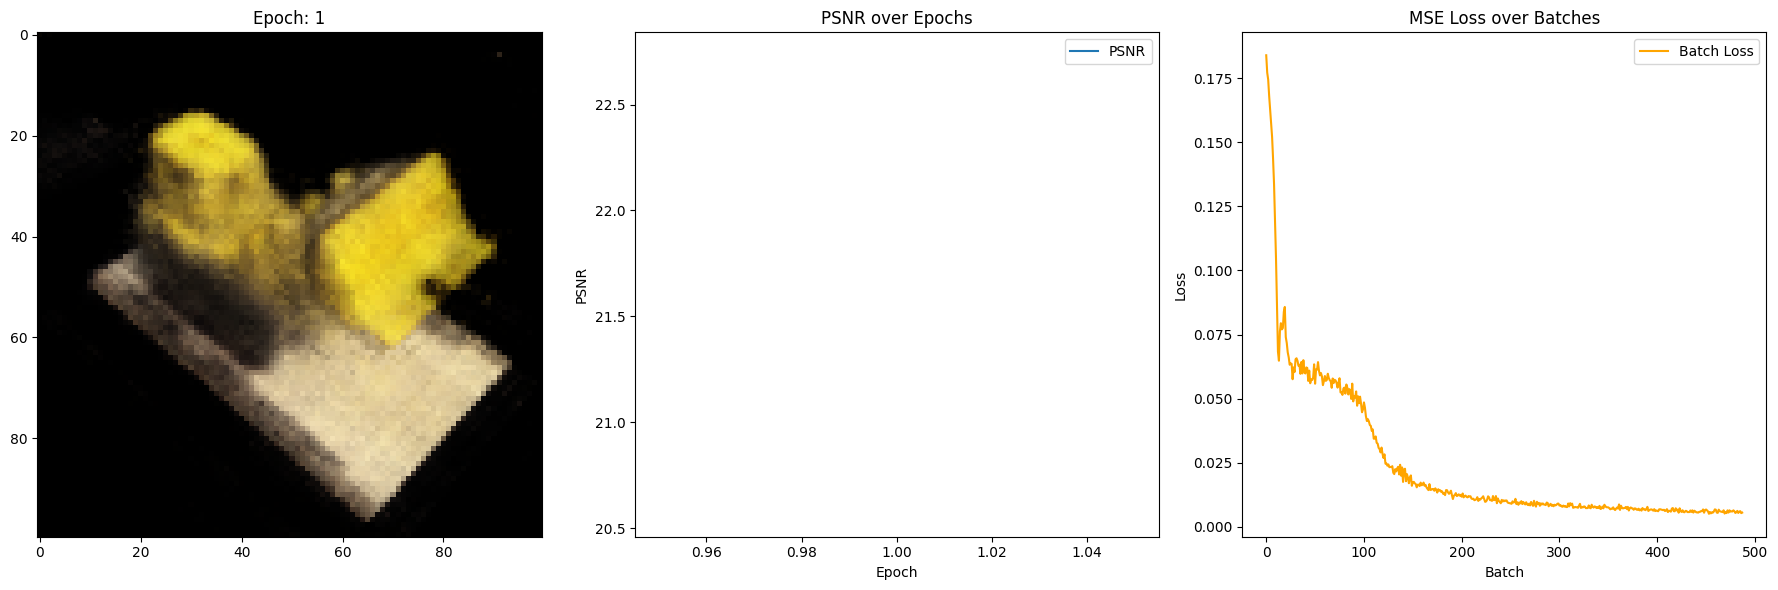

100%|██████████| 488/488 [02:25<00:00,  3.34it/s]


PSNR score=tensor([24.6690])
Average loss per epoch = 0.0040331735126826855


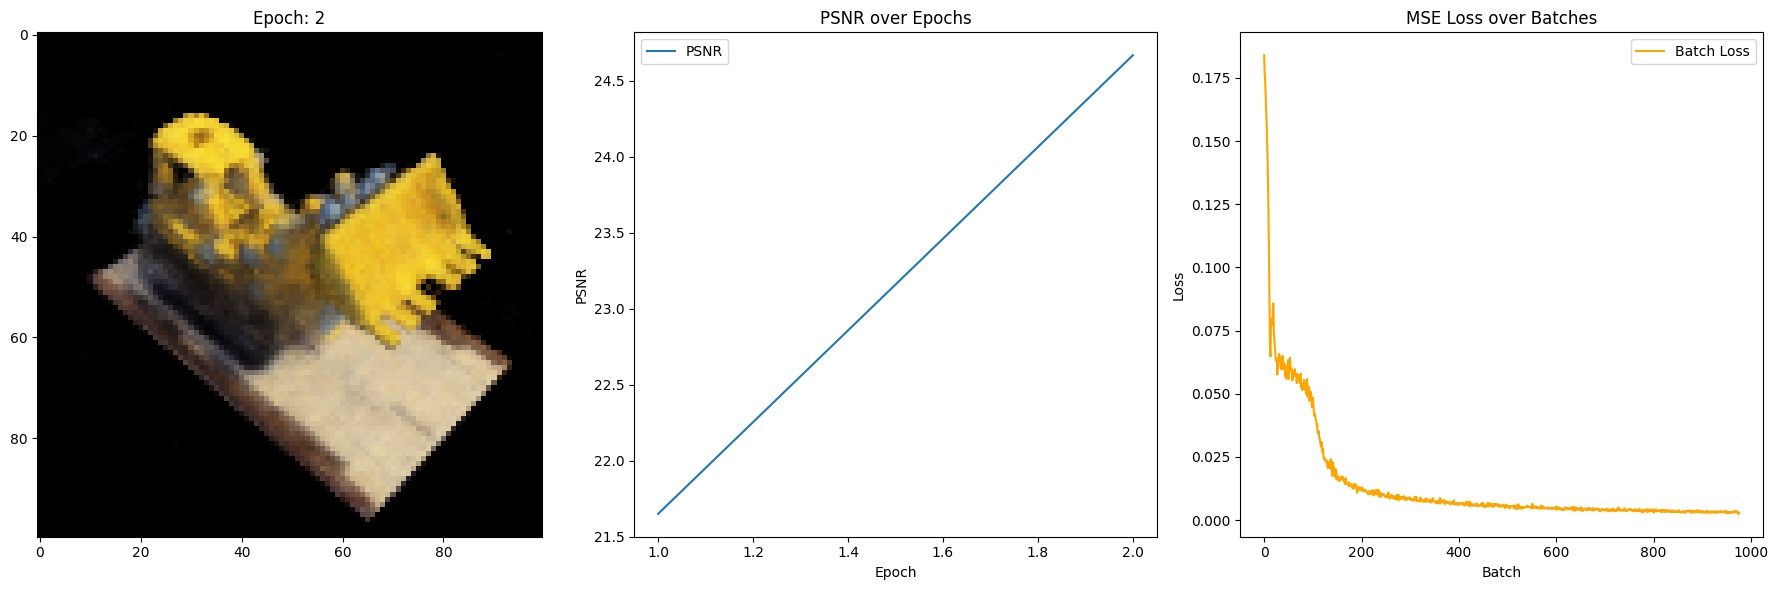

100%|██████████| 488/488 [02:26<00:00,  3.33it/s]


PSNR score=tensor([26.3122])
Average loss per epoch = 0.002527800066345066


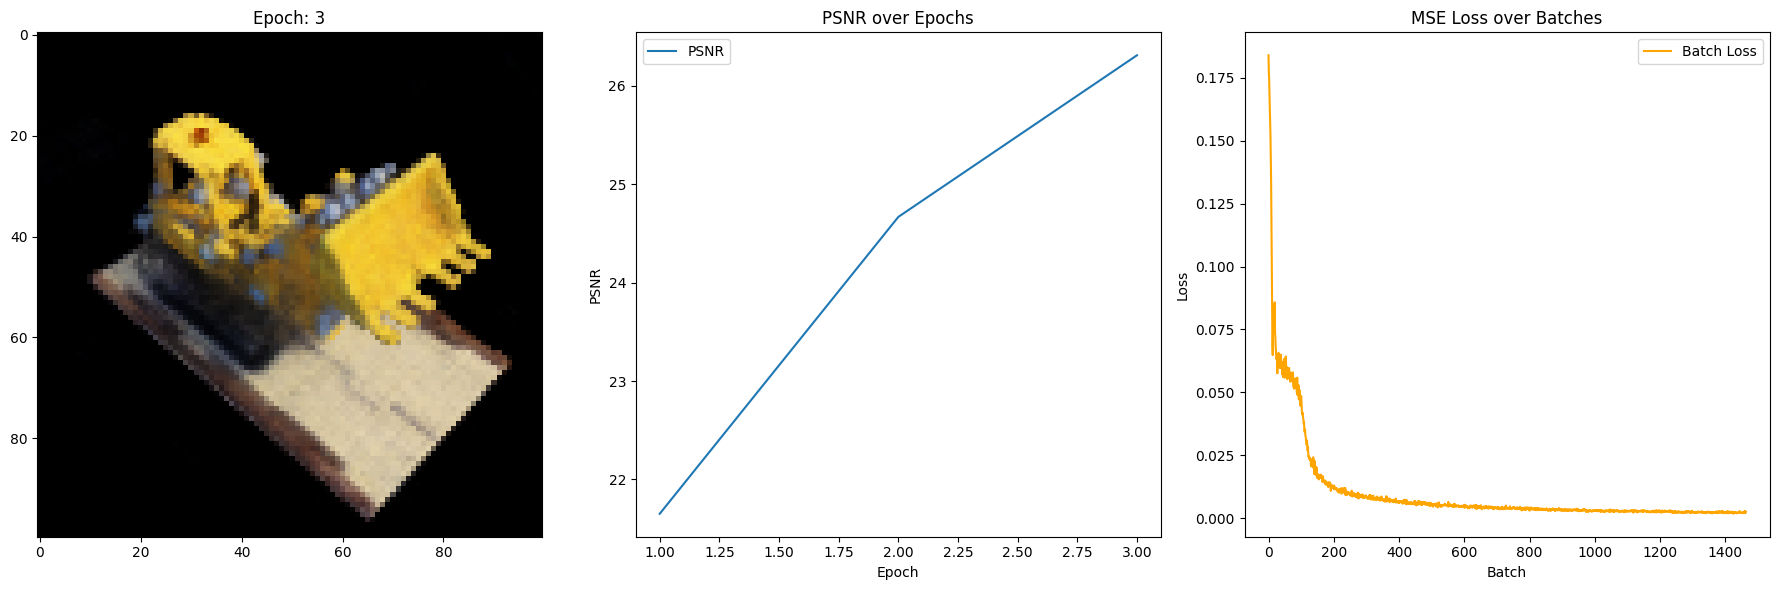

100%|██████████| 488/488 [02:25<00:00,  3.35it/s]


PSNR score=tensor([27.2167])
Average loss per epoch = 0.0018787391781501595


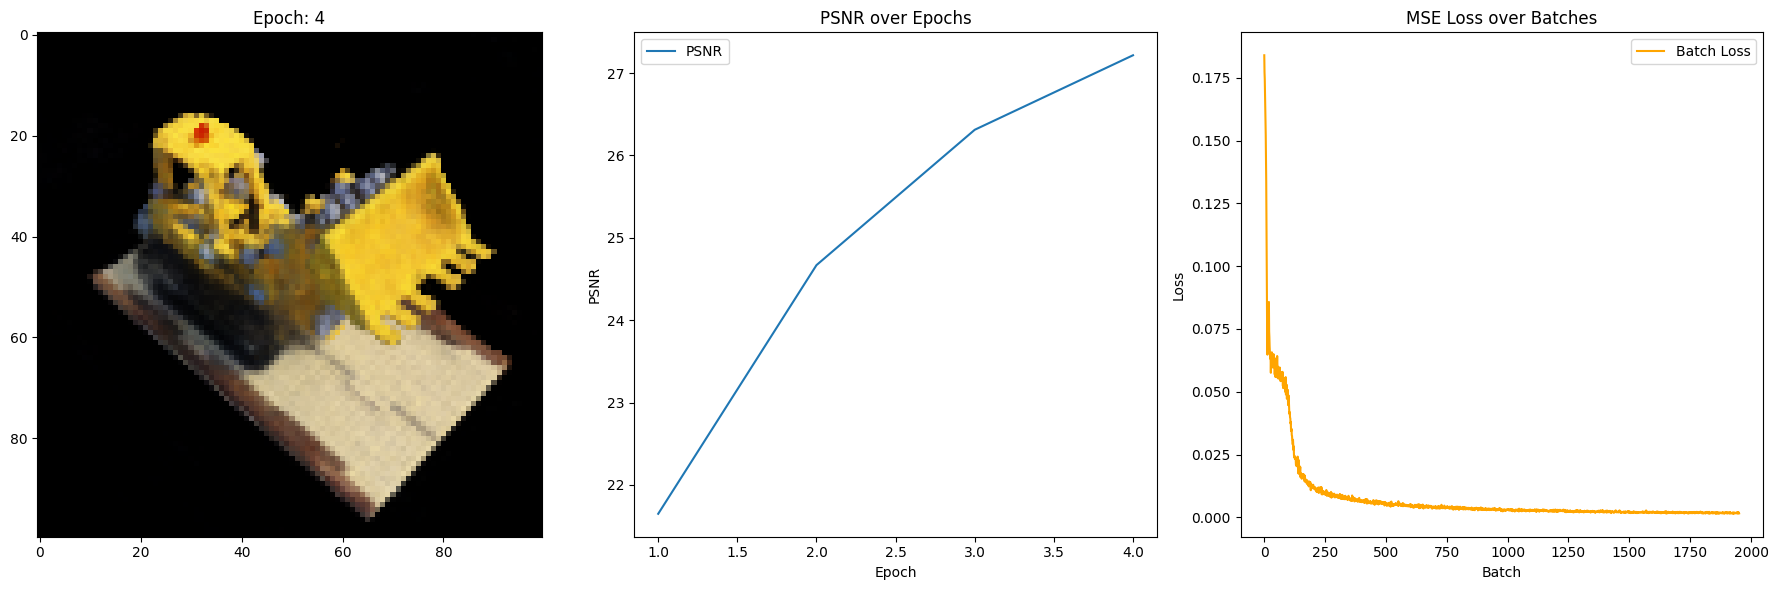

100%|██████████| 488/488 [02:26<00:00,  3.34it/s]


PSNR score=tensor([27.9068])
Average loss per epoch = 0.001584729461951685


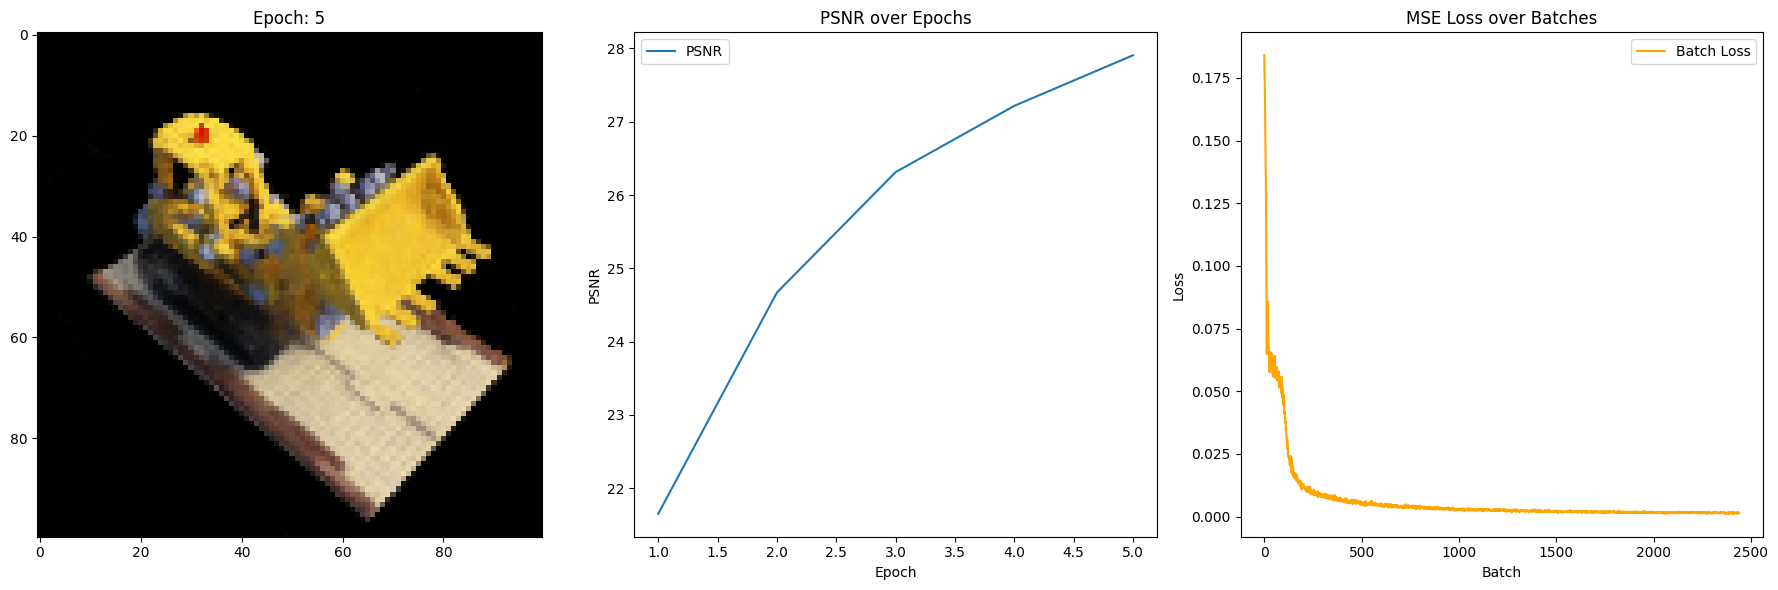

100%|██████████| 488/488 [02:26<00:00,  3.33it/s]


PSNR score=tensor([28.2554])
Average loss per epoch = 0.0013839428520143093


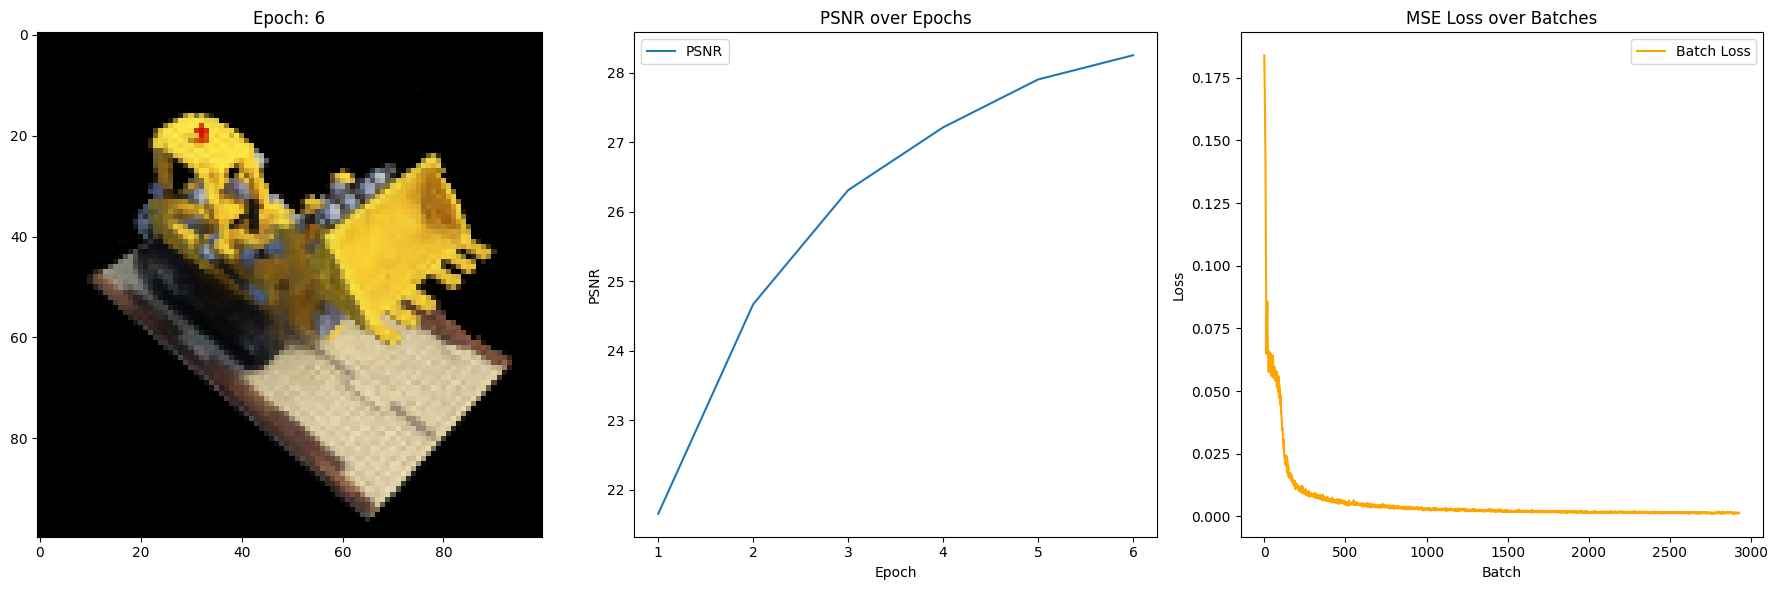

100%|██████████| 488/488 [02:26<00:00,  3.33it/s]


PSNR score=tensor([28.8252])
Average loss per epoch = 0.0012488595552820727


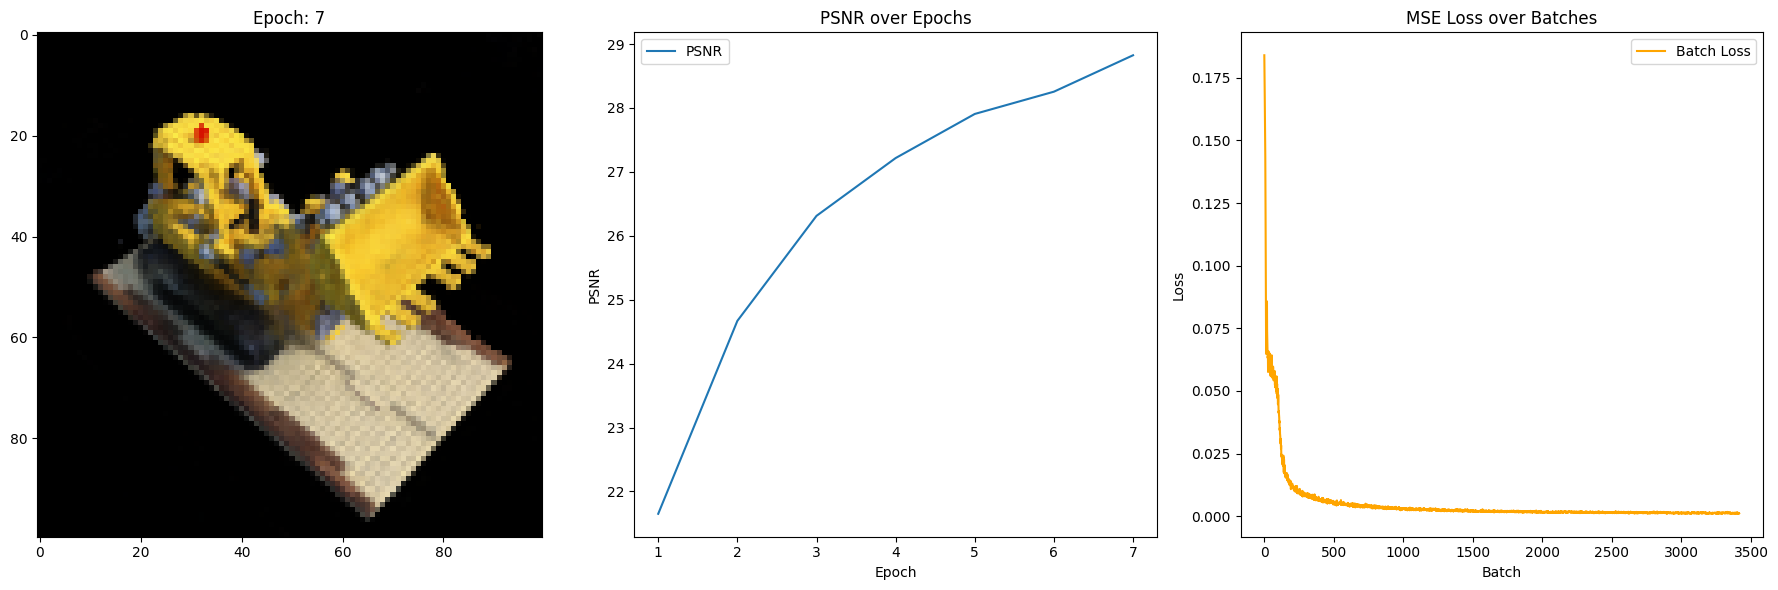

100%|██████████| 488/488 [02:26<00:00,  3.33it/s]


PSNR score=tensor([29.3014])
Average loss per epoch = 0.0011302126972548678


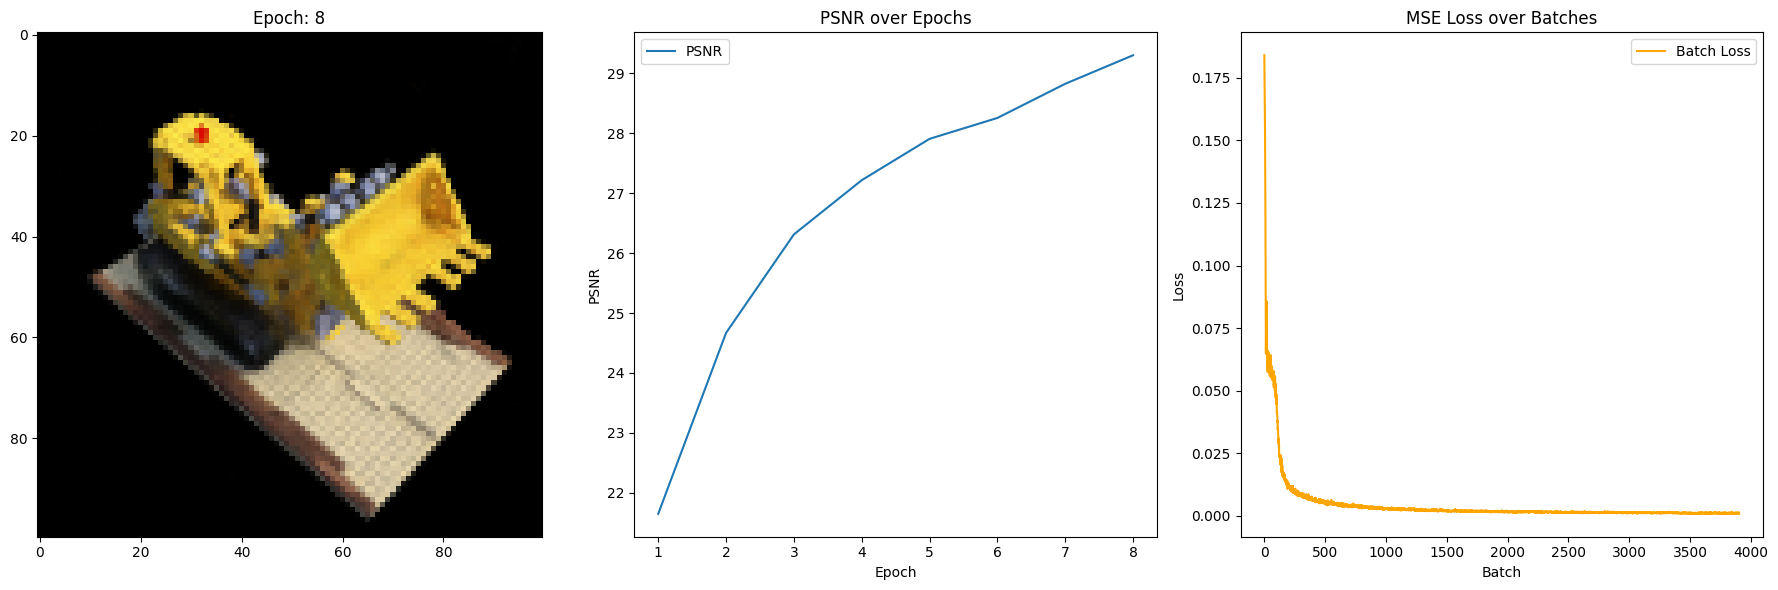

100%|██████████| 488/488 [02:26<00:00,  3.33it/s]


PSNR score=tensor([29.3545])
Average loss per epoch = 0.0010322569748987902


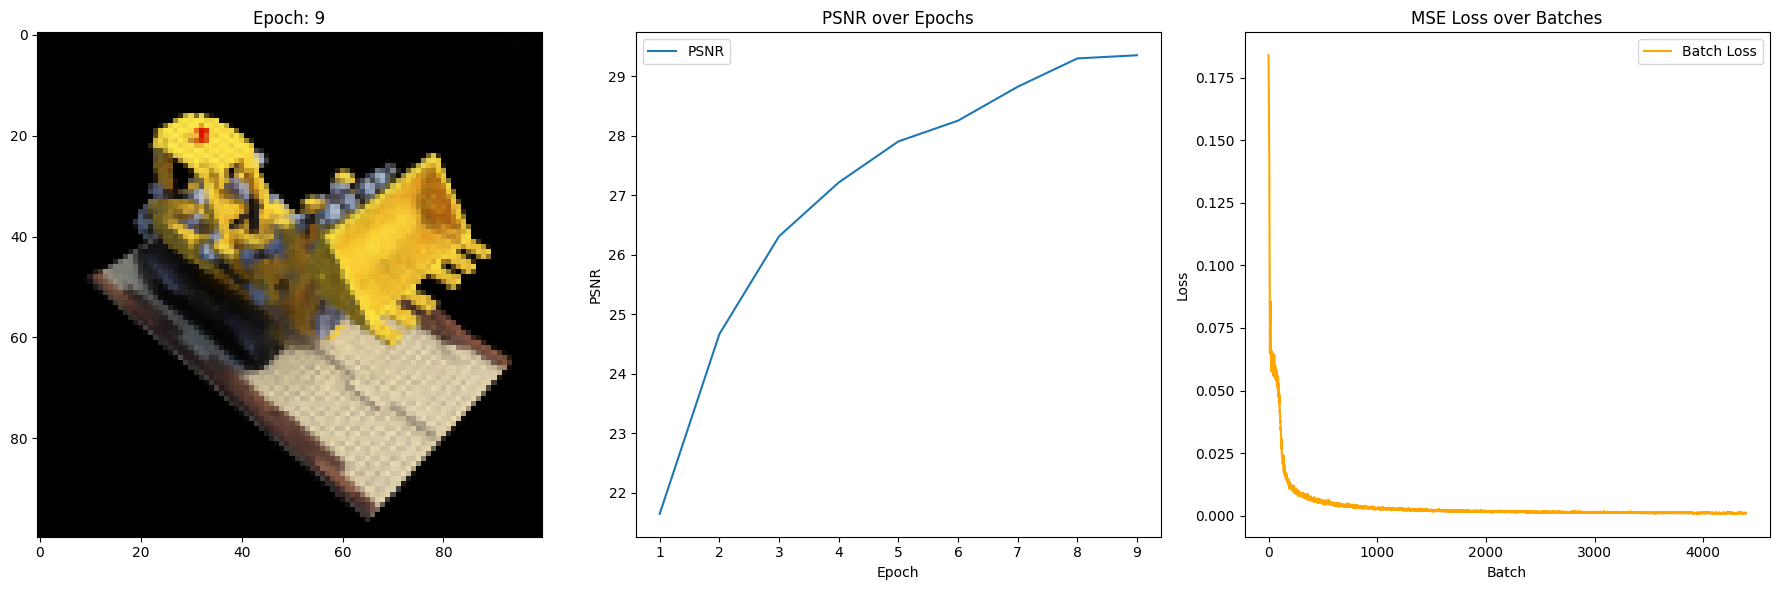

100%|██████████| 488/488 [02:26<00:00,  3.34it/s]


PSNR score=tensor([29.7671])
Average loss per epoch = 0.0009280236808394204


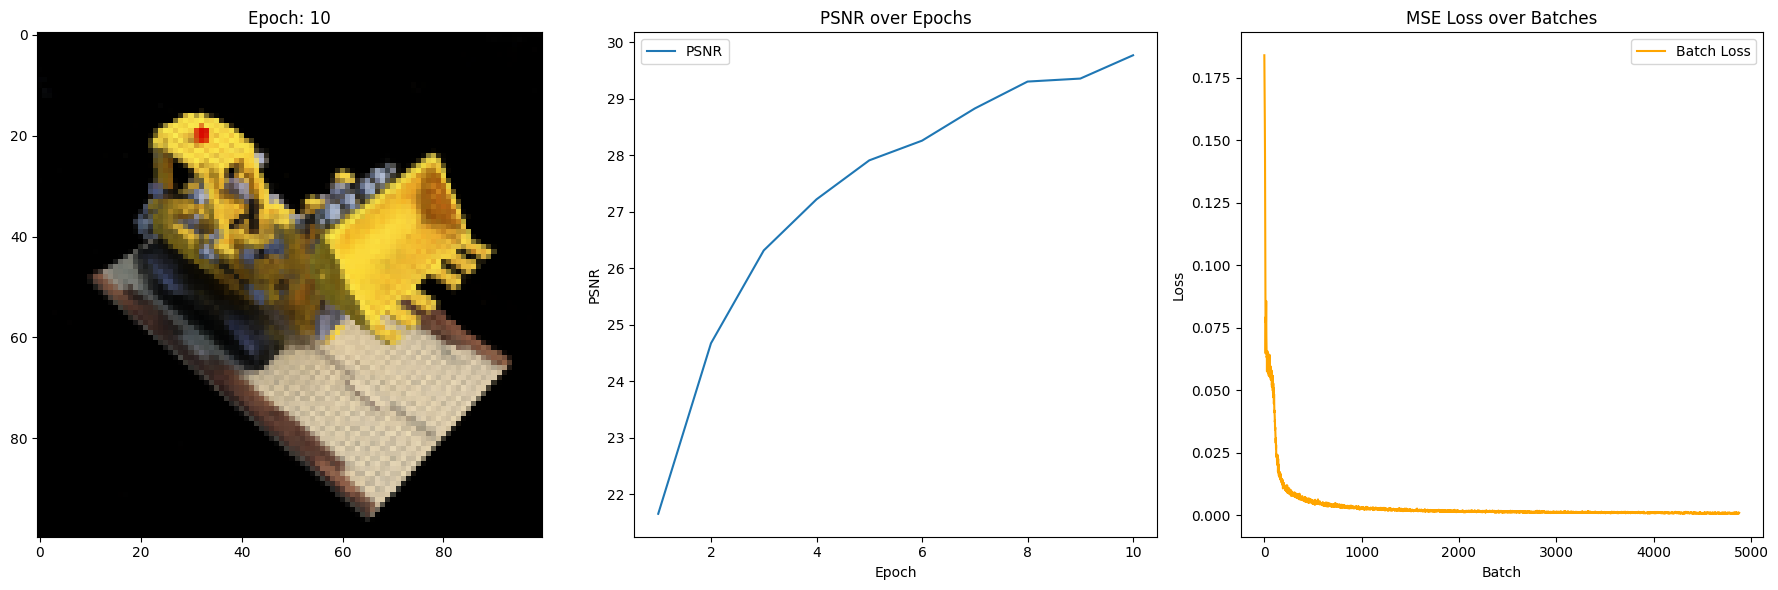

100%|██████████| 488/488 [02:25<00:00,  3.35it/s]


PSNR score=tensor([30.1758])
Average loss per epoch = 0.0008685319907734263


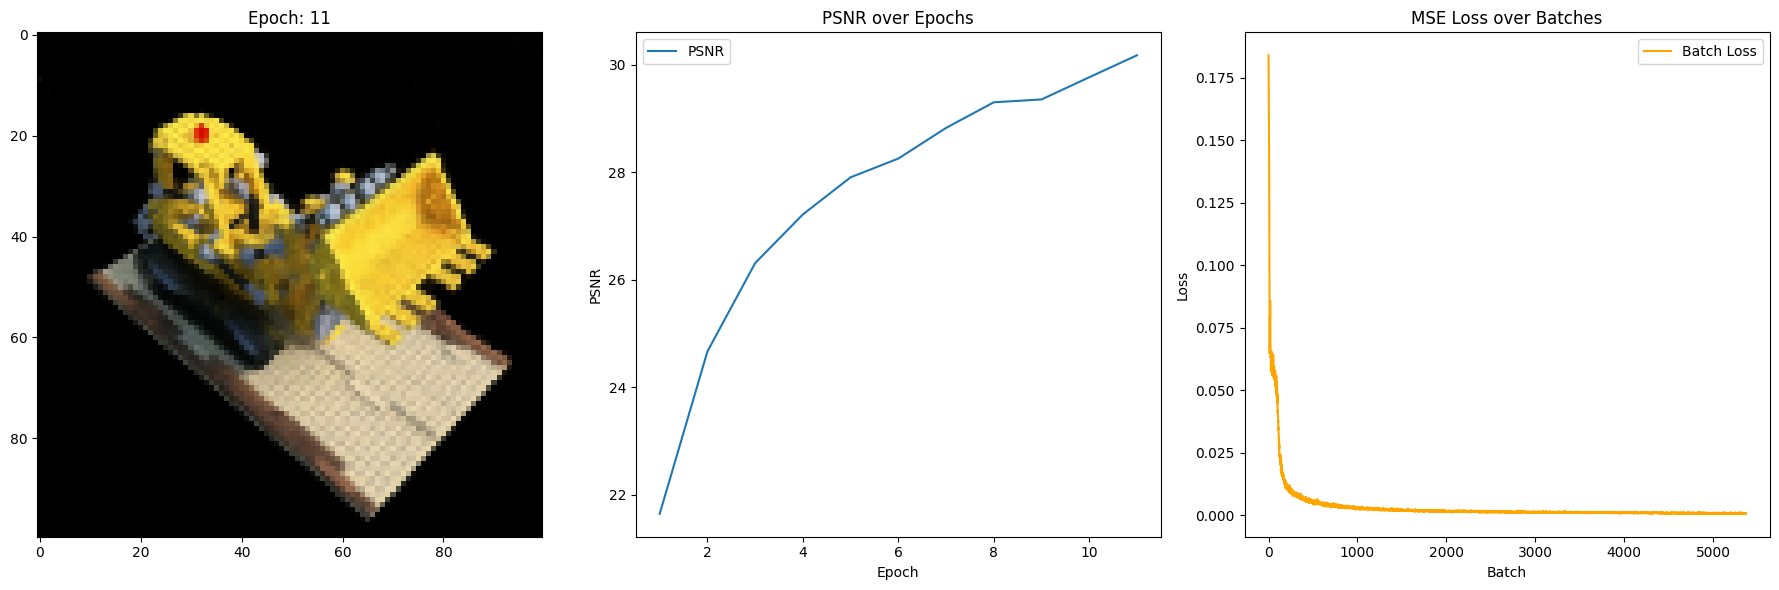

100%|██████████| 488/488 [02:26<00:00,  3.33it/s]


PSNR score=tensor([30.2907])
Average loss per epoch = 0.0008081223231933049


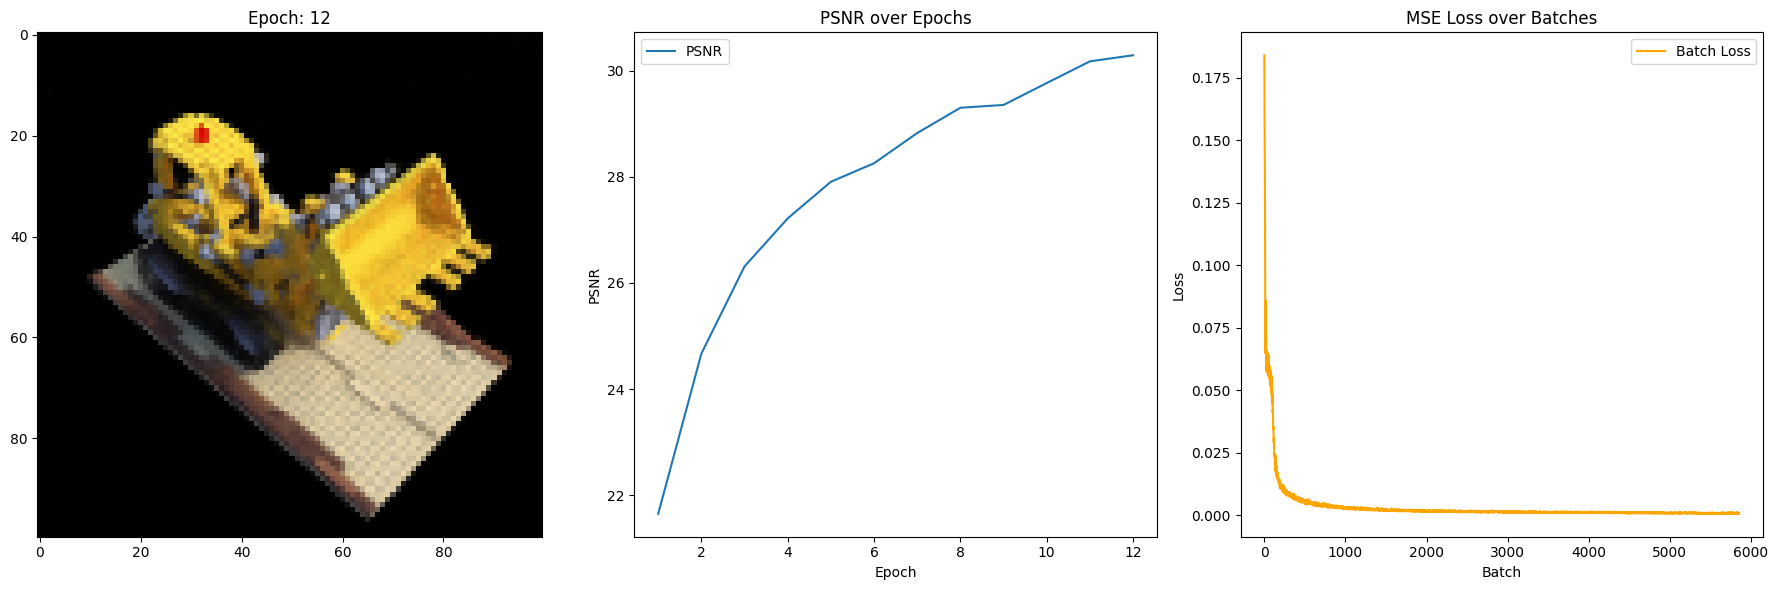

100%|██████████| 488/488 [02:26<00:00,  3.33it/s]


PSNR score=tensor([30.9189])
Average loss per epoch = 0.0007682959178174449


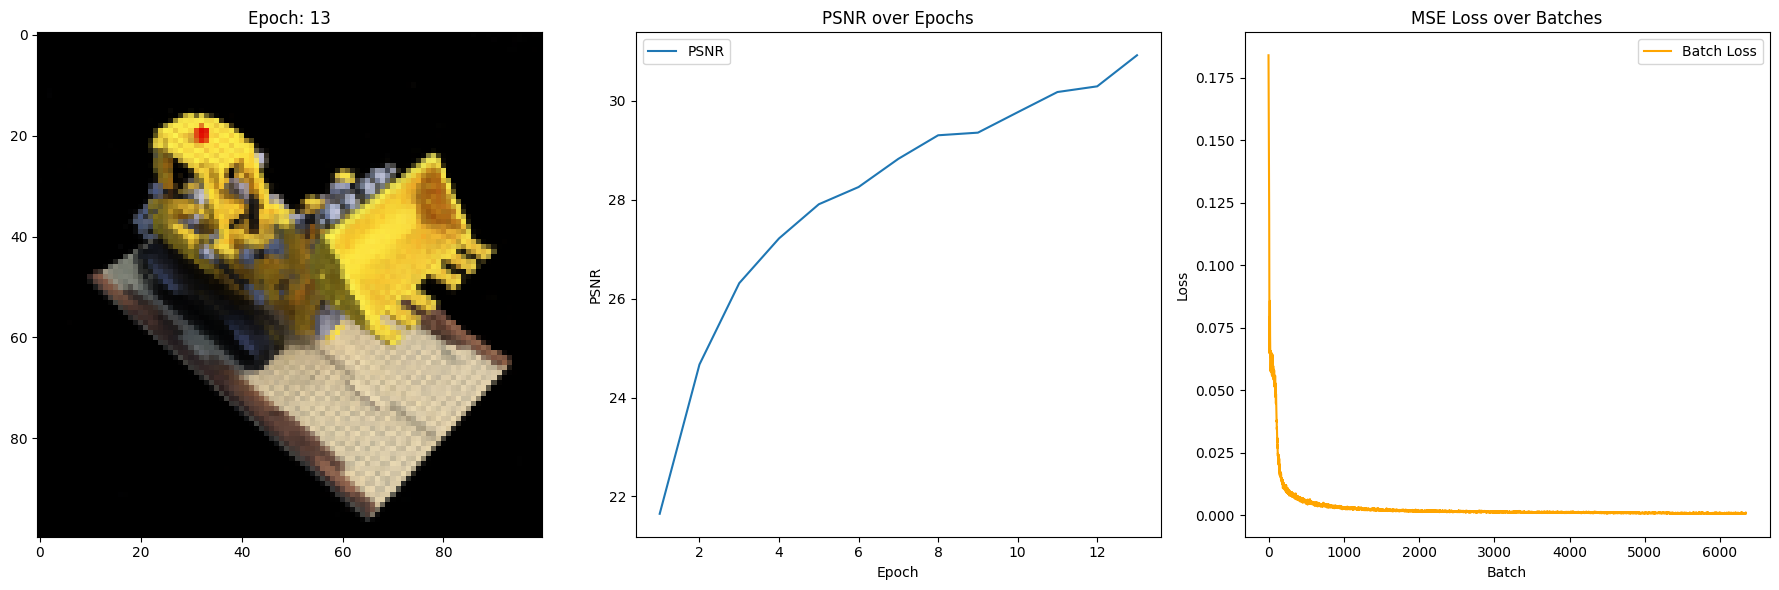

100%|██████████| 488/488 [02:26<00:00,  3.33it/s]


PSNR score=tensor([30.6512])
Average loss per epoch = 0.0007433376951786292


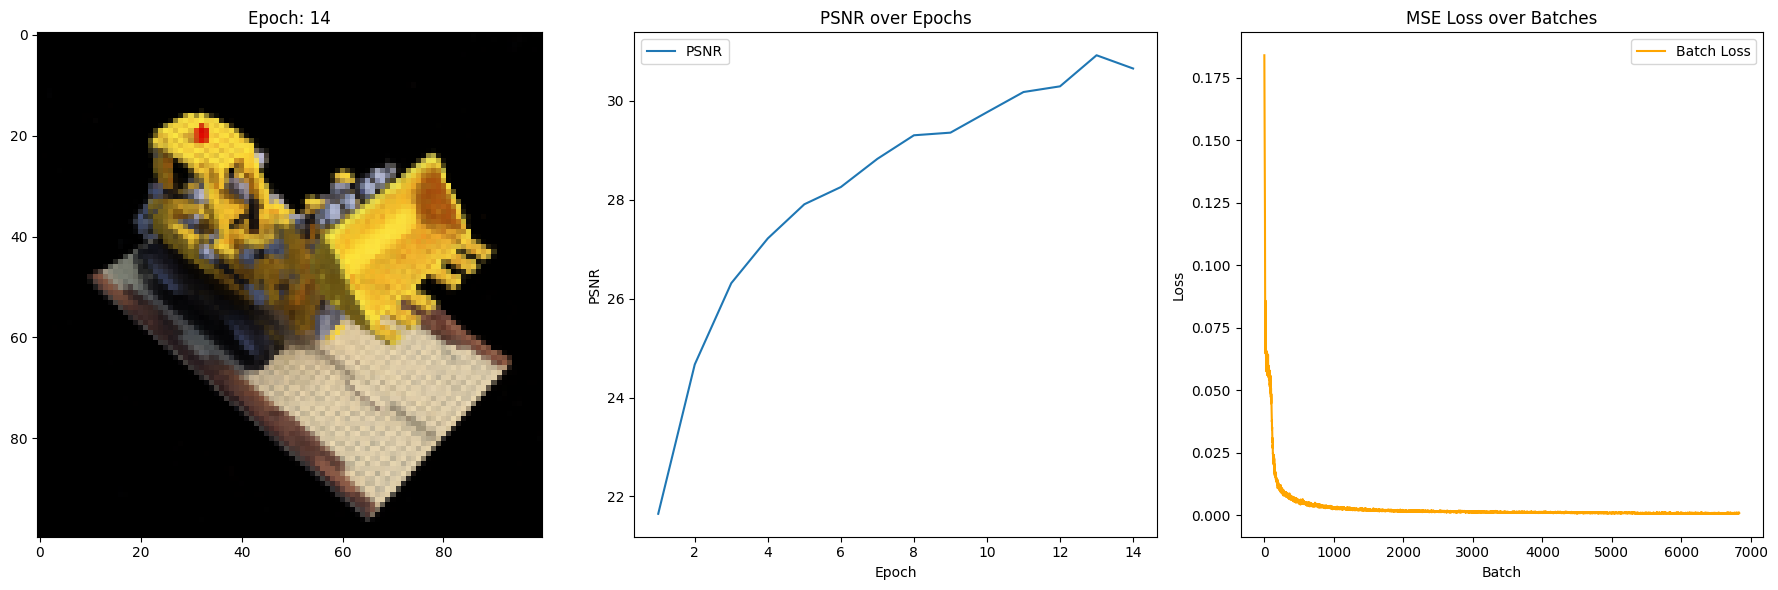

100%|██████████| 488/488 [02:25<00:00,  3.34it/s]


PSNR score=tensor([31.0765])
Average loss per epoch = 0.0006997249333462755


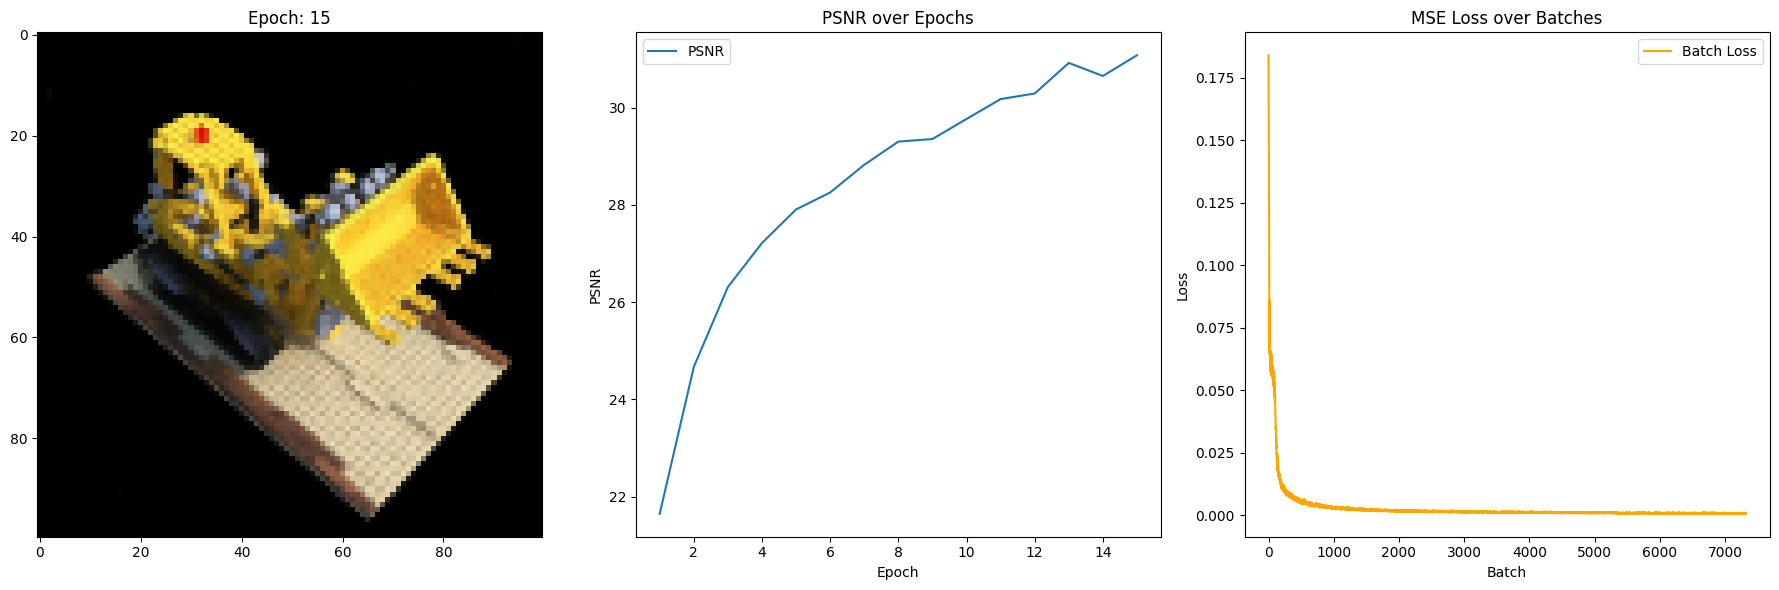

100%|██████████| 488/488 [02:25<00:00,  3.34it/s]


PSNR score=tensor([31.3331])
Average loss per epoch = 0.0006779531209221964


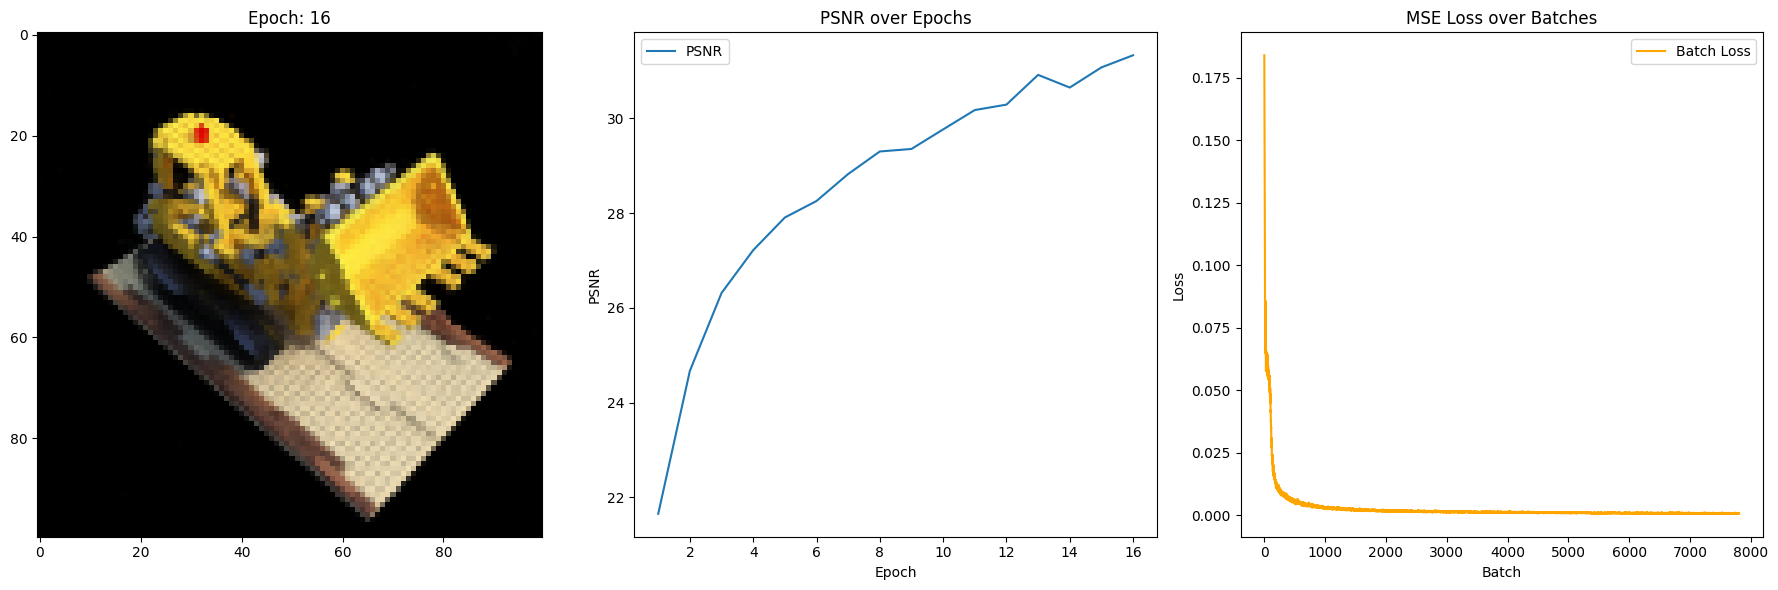

100%|██████████| 488/488 [02:25<00:00,  3.35it/s]


PSNR score=tensor([31.6324])
Average loss per epoch = 0.0006537538174598012


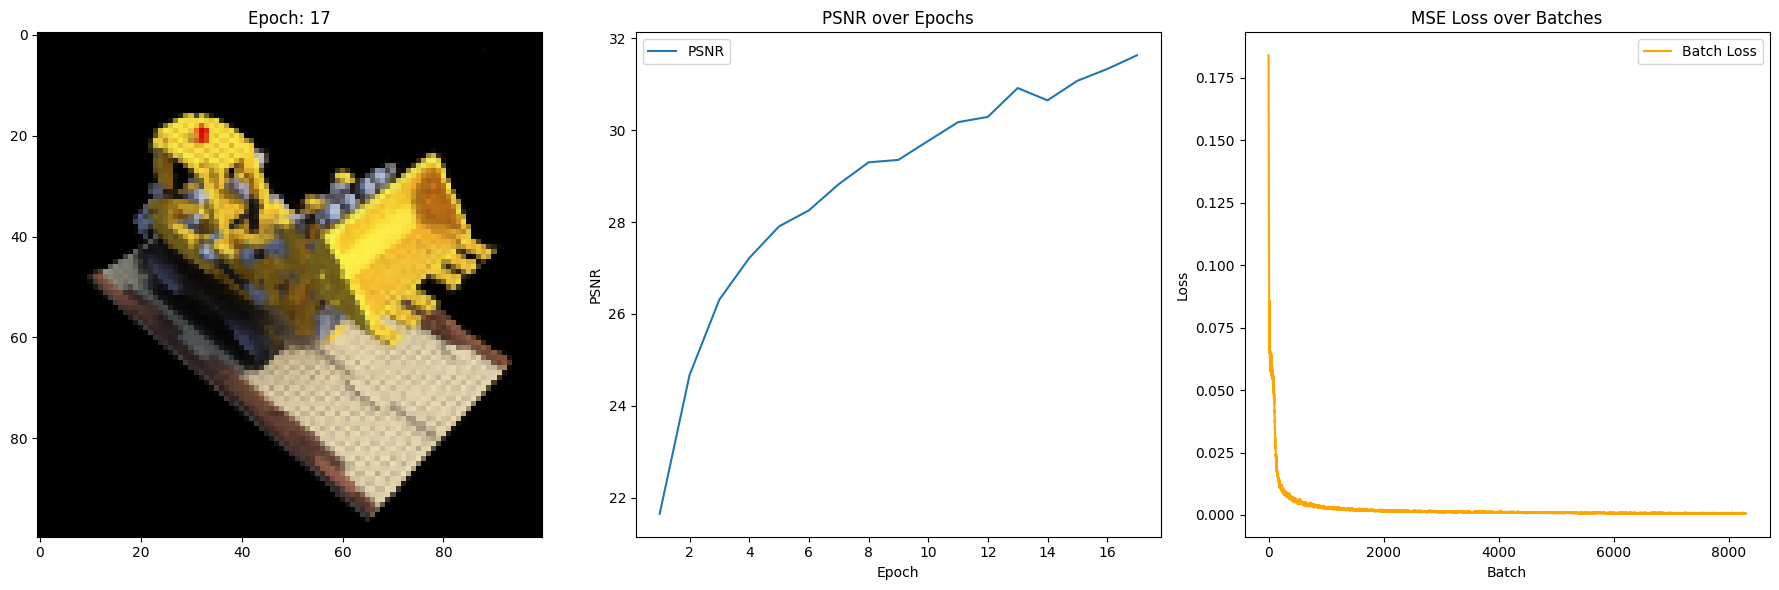

100%|██████████| 488/488 [02:25<00:00,  3.36it/s]


PSNR score=tensor([31.8126])
Average loss per epoch = 0.0006302866548467732


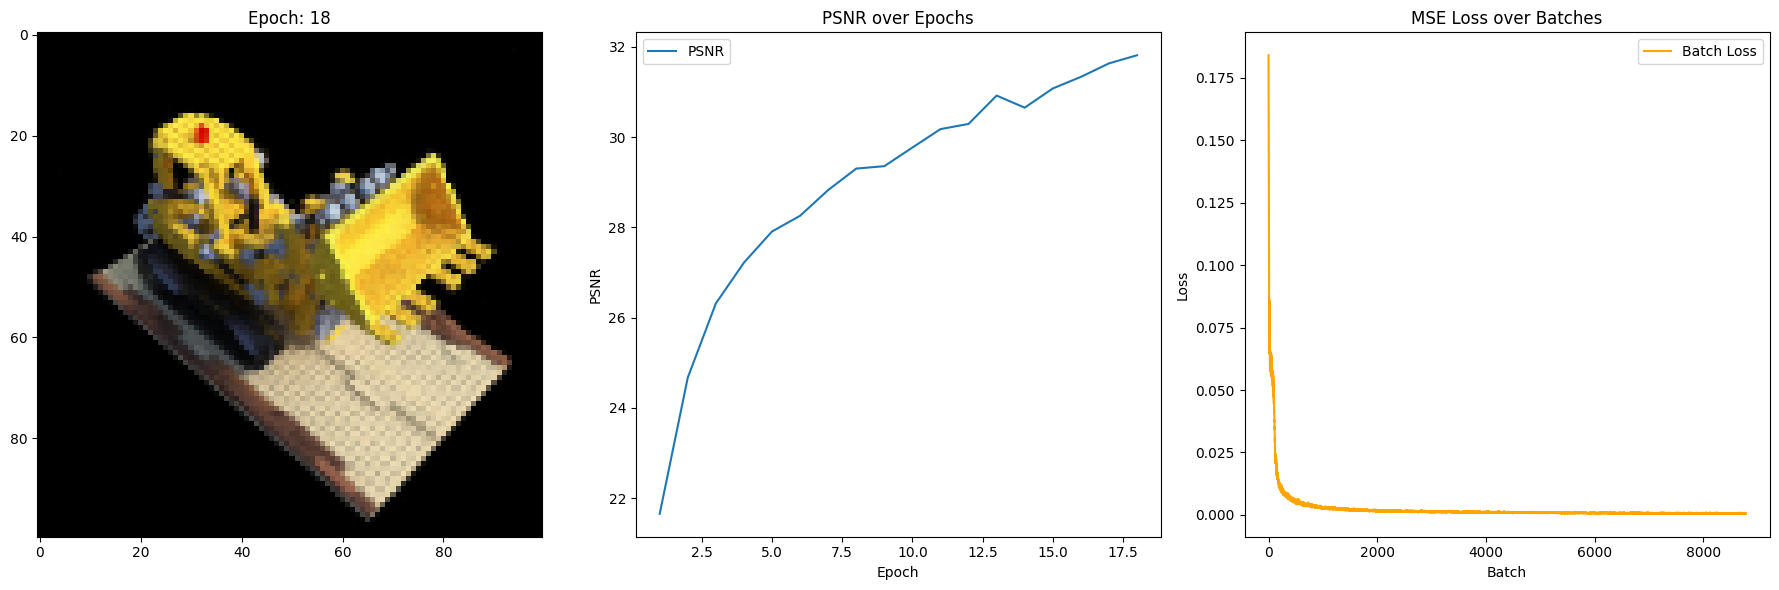

100%|██████████| 488/488 [02:25<00:00,  3.35it/s]


PSNR score=tensor([31.7014])
Average loss per epoch = 0.0006102356968708069


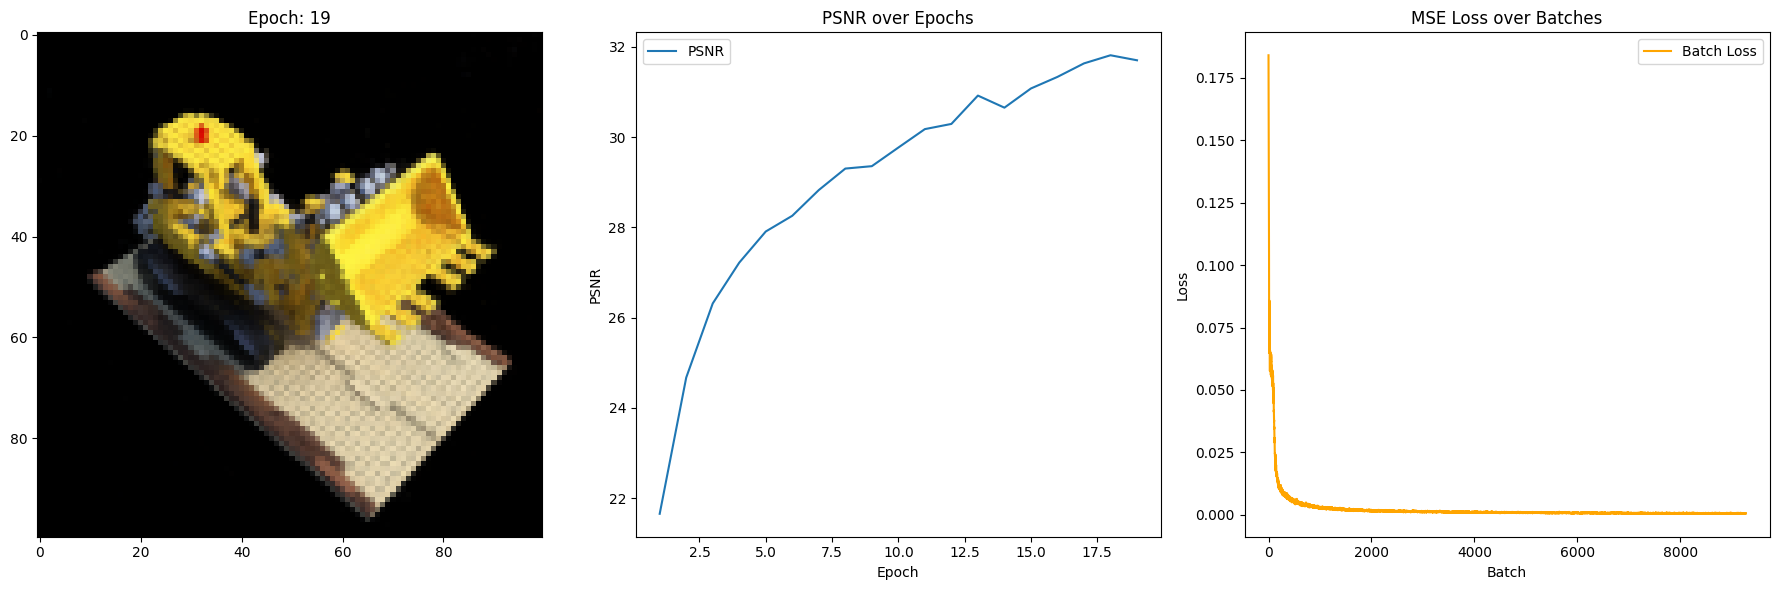

100%|██████████| 488/488 [02:25<00:00,  3.35it/s]


PSNR score=tensor([31.9303])
Average loss per epoch = 0.0005881980299013552


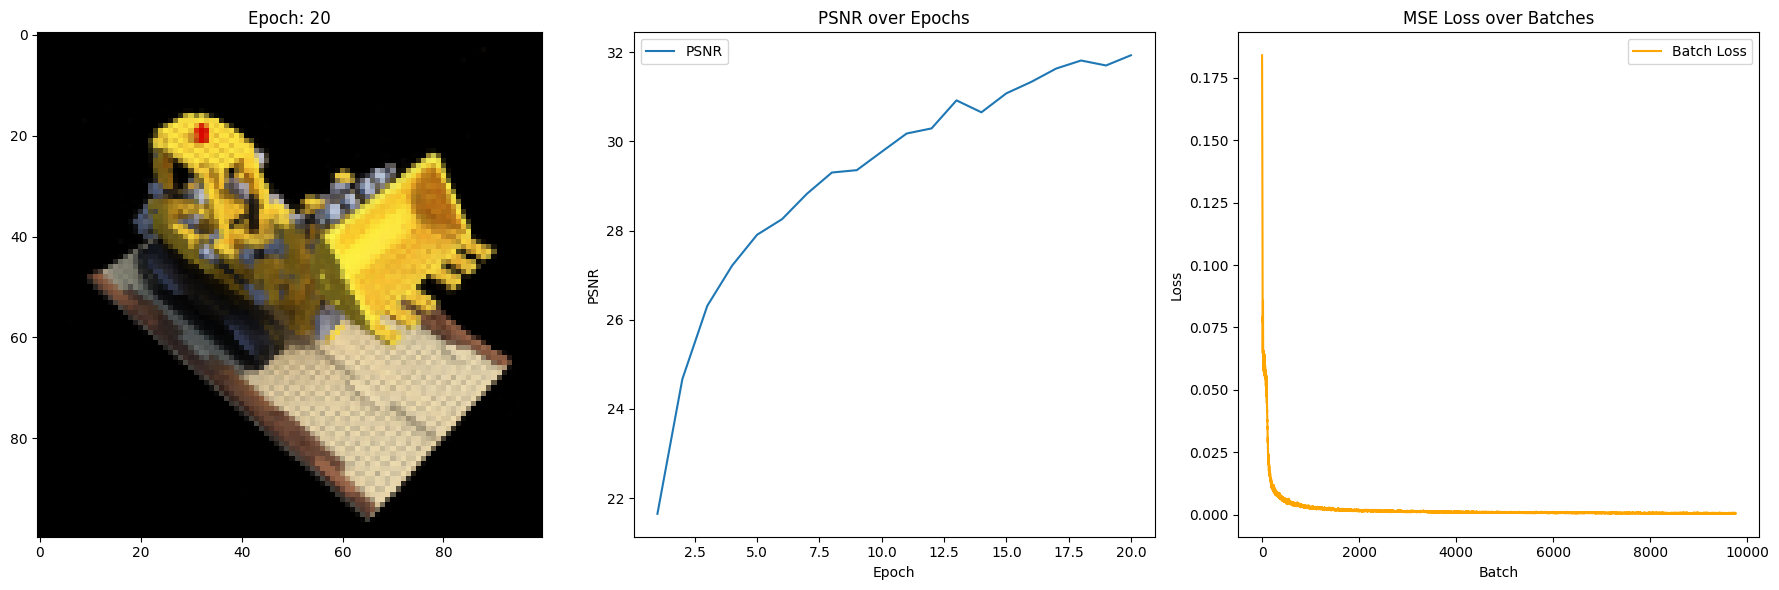

In [6]:

# Sample rays for all images
sampled_rays = [
    sample_rays_numpy(height, width, focal_length, pose_data[img_idx])
    for img_idx in range(num_training_images)
]

# Unpack sampled rays
ray_origins_list, ray_directions_list = zip(*sampled_rays)

# Reshape rays and images
ray_origins_list = [orig.reshape(-1, 3) for orig in ray_origins_list]
ray_directions_list = [dir.reshape(-1, 3) for dir in ray_directions_list]
list_rays = [image_data[img_idx].reshape(-1, 3) for img_idx in range(num_training_images)]

# Convert lists to numpy arrays and stack them vertically
ray_origins_array = np_lib.vstack(ray_origins_list)
ray_directions_array = np_lib.vstack(ray_directions_list)
ray_rgb_array = np_lib.vstack(list_rays)

# Verify the shapes to ensure correctness (optional debugging step)
assert ray_origins_array.shape[0] == ray_directions_array.shape[0] == ray_rgb_array.shape[0], "Mismatch in number of rays"

# Combine all ray components into a single numpy array
rays_combined_array = np_lib.hstack([ray_origins_array, ray_directions_array, ray_rgb_array])

# Convert the combined numpy array to a PyTorch tensor
rays = torch_lib.tensor(rays_combined_array, device=computation_device)

# parameters of training

batch_size = 2048
num_total_rays = rays.shape[0]
print(f"The number of batches is {num_total_rays // batch_size} and each batch has {batch_size} rays")


num_epochs = 20
psnr_history = []
epoch_indices = []
depth_bounds = (2.0, 6.0)
sample_counts = (64, 32)
directions_use_view = True

# Sample rays for the test image
test_ray_origins, test_ray_directions = sample_rays_numpy(height, width, focal_length, test_pose)

# Create a dictionary to store the test data
test_data = {
    'ray_origins': test_ray_origins,
    'ray_directions': test_ray_directions,
    'rgb': test_image
}

# Convert all test data to PyTorch tensors and store them back in the dictionary
test_data_tensors = {key: torch_lib.tensor(value, device=computation_device) for key, value in test_data.items()}

# Extract the tensors from the dictionary
test_ray_origins_tensor = test_data_tensors['ray_origins']
test_ray_directions_tensor = test_data_tensors['ray_directions']
test_rgb_tensor = test_data_tensors['rgb']

# train

nerf_model = NeuralRadianceField(directions_use_view=directions_use_view).to(computation_device)
optimizer_adm = optim_lib.Adam(nerf_model.parameters(), lr=5e-4)
mean_squared_error = nn_lib.MSELoss()

num_batches = num_total_rays // batch_size
epoch_indices = []
psnr_history = []
batch_loss_history = []

for epoch in range(num_epochs):
    # Randomly permute the order of rays
    random_indices = torch_lib.randperm(num_total_rays)
    permuted_rays = rays[random_indices, :]

    # Split permuted rays into batches for training
    training_batches = iter(torch_lib.chunk(permuted_rays, int(num_total_rays / batch_size), dim=0))

    epoch_loss = 0

    for batch_index in progress_lib(range(num_batches)):
        batch_rays = next(training_batches)

        trial_dim = -1
        ray_origins_batch, ray_directions_batch, target_rgb_batch = torch_lib.chunk(batch_rays, 3, dim=trial_dim)
        batch_ray_origins_directions = (ray_origins_batch, ray_directions_batch)
        predicted_rgb, _, __ = rendering(nerf_model, batch_ray_origins_directions, bounds=depth_bounds, num_samples=sample_counts, comp_device=computation_device, directions_use_view=directions_use_view)
        losses = mean_squared_error(predicted_rgb, target_rgb_batch)
        optimizer_adm.zero_grad()

        losses.backward()

        optimizer_adm.step()

        epoch_loss += losses.item()
        batch_loss_history.append(losses.item())  # Collecting batch loss

    # Average loss over all batches in the epoch
    epoch_loss /= num_batches

    with torch_lib.no_grad():
        pred_rgb = []
        test_shape = test_ray_origins_tensor.shape[0]
        for ray_index in range(test_shape):
            # Extract the origin and direction for the test ray at the specified index and combine them using zip
            test_ray_data = next(zip(
                test_ray_origins_tensor[ray_index].unsqueeze(0),
                test_ray_directions_tensor[ray_index].unsqueeze(0)
            ))

            # Flatten the tuple
            ray_origins_directions_test = tuple(test_ray_data)

            predicted_rgb, _, __ = rendering(nerf_model, ray_origins_directions_test, bounds=depth_bounds, num_samples=sample_counts, comp_device=computation_device, directions_use_view=directions_use_view)

            fix_rgb_pred = predicted_rgb.unsqueeze(0)

            pred_rgb.append(fix_rgb_pred)

        predicted_rgb_tensor = torch_lib.cat(pred_rgb, dim=0)
        test_loss = mean_squared_error(predicted_rgb_tensor, test_rgb_tensor).cpu()
        psnr_value = -10.0 * torch_lib.log(test_loss).item() / torch_lib.log(torch_lib.tensor([10.0]))
        print(f"PSNR score={psnr_value}")
        print(f"Average loss per epoch = {epoch_loss}")

        epoch_step = epoch + 1
        epoch_indices.append(epoch_step)
        psnr_history.append(psnr_value)

        # Plot PSNR, Training Loss, and Batch Loss
        plot_lib.figure(figsize=(18, 6))

        # Plot predicted RGB
        plot_lib.subplot(131)
        var_pred = predicted_rgb_tensor.cpu().detach()
        plot_lib.imshow(var_pred.numpy())
        plot_lib.title(f'Epoch: {epoch_step}')

        # Plot PSNR
        plot_lib.subplot(132)
        plot_lib.plot(epoch_indices, psnr_history, label='PSNR')
        plot_lib.xlabel('Epoch')
        plot_lib.ylabel('PSNR')
        plot_lib.title('PSNR over Epochs')
        plot_lib.legend()

        # Plot Batch Loss
        plot_lib.subplot(133)
        plot_lib.plot(batch_loss_history, label='Batch Loss', color='orange')
        plot_lib.xlabel('Batch')
        plot_lib.ylabel('Loss')
        plot_lib.title('MSE Loss over Batches')
        plot_lib.legend()

        plot_lib.tight_layout()
        plot_lib.show()


In [7]:
import numpy as np_lib
import torch as torch_lib
import matplotlib.pyplot as plot_lib
from IPython.display import HTML as ipython_html_display
from ipywidgets import widgets as widget_lib, interactive as interactive_lib
from base64 import b64encode as encode_base64
import imageio as imageio_lib

def create_rotation_matrix_phi(angle_phi):
    return np_lib.array([
        [1, 0, 0, 0],
        [0, np_lib.cos(angle_phi), -np_lib.sin(angle_phi), 0],
        [0, np_lib.sin(angle_phi), np_lib.cos(angle_phi), 0],
        [0, 0, 0, 1],
    ], dtype=float)

def create_rotation_matrix_theta(angle_theta):
    return np_lib.array([
        [np_lib.cos(angle_theta), 0, -np_lib.sin(angle_theta), 0],
        [0, 1, 0, 0],
        [np_lib.sin(angle_theta), 0, np_lib.cos(angle_theta), 0],
        [0, 0, 0, 1],
    ], dtype=float)

# Define the transformation functions
def create_translation_matrix(distance):
    return np_lib.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, distance],
        [0, 0, 0, 1],
    ], dtype=float)

def calculate_camera_pose(theta_angle, phi_angle, cam_radius):
    cam_to_world_matrix = create_translation_matrix(cam_radius)
    cam_to_world_matrix = create_rotation_matrix_phi(phi_angle / 180. * np_lib.pi) @ cam_to_world_matrix
    cam_to_world_matrix = create_rotation_matrix_theta(theta_angle / 180. * np_lib.pi) @ cam_to_world_matrix
    cam_to_world_matrix = np_lib.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ cam_to_world_matrix
    return cam_to_world_matrix



In [8]:
import numpy as np_lib
import torch as torch_lib
from tqdm import tqdm as progress_lib
import imageio as imageio_lib

rendered_frames = []
pred_rgb = []
for theta_angle in progress_lib(np_lib.linspace(0.0, 360.0, 120, endpoint=False)):
    with torch_lib.no_grad():
        camera_to_world_matrix = calculate_camera_pose(theta_angle, -30.0, 4.0)
        ray_origins, ray_directions = sample_rays_numpy(height, width, focal_length, camera_to_world_matrix[:3, :4])

        for ray_index in range(ray_origins.shape[0]):
            ray_origins_directions_test = (T.tensor(ray_origins[ray_index], dtype=T.float32).to(computation_device),T.tensor(ray_directions[ray_index], dtype=T.float32).to(computation_device))

            rgb_output, depth_output, acc_output = rendering(
                nerf_model, ray_origins_directions_test, bounds=depth_bounds, num_samples=sample_counts, comp_device=computation_device, directions_use_view=directions_use_view
            )

            rgb_output = rgb_output.unsqueeze(0)

            pred_rgb.append(rgb_output)
    predicted_rgb_tensor = torch_lib.cat(pred_rgb, dim=0)
    rendered_frames.append((255 * np_lib.clip(predicted_rgb_tensor.cpu().numpy(), 0, 1)).astype(np_lib.uint8))
    pred_rgb=[]

video_filename = 'rendered_video.mp4'
imageio_lib.mimwrite(video_filename, rendered_frames, fps=20, quality=10)


100%|██████████| 120/120 [01:36<00:00,  1.25it/s]


In [9]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('rendered_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

The number of batches is 488 and each batch has 2048 rays


100%|██████████| 488/488 [01:19<00:00,  6.18it/s]


PSNR score=tensor([21.1339])
Average loss per epoch = 0.024204430300131686


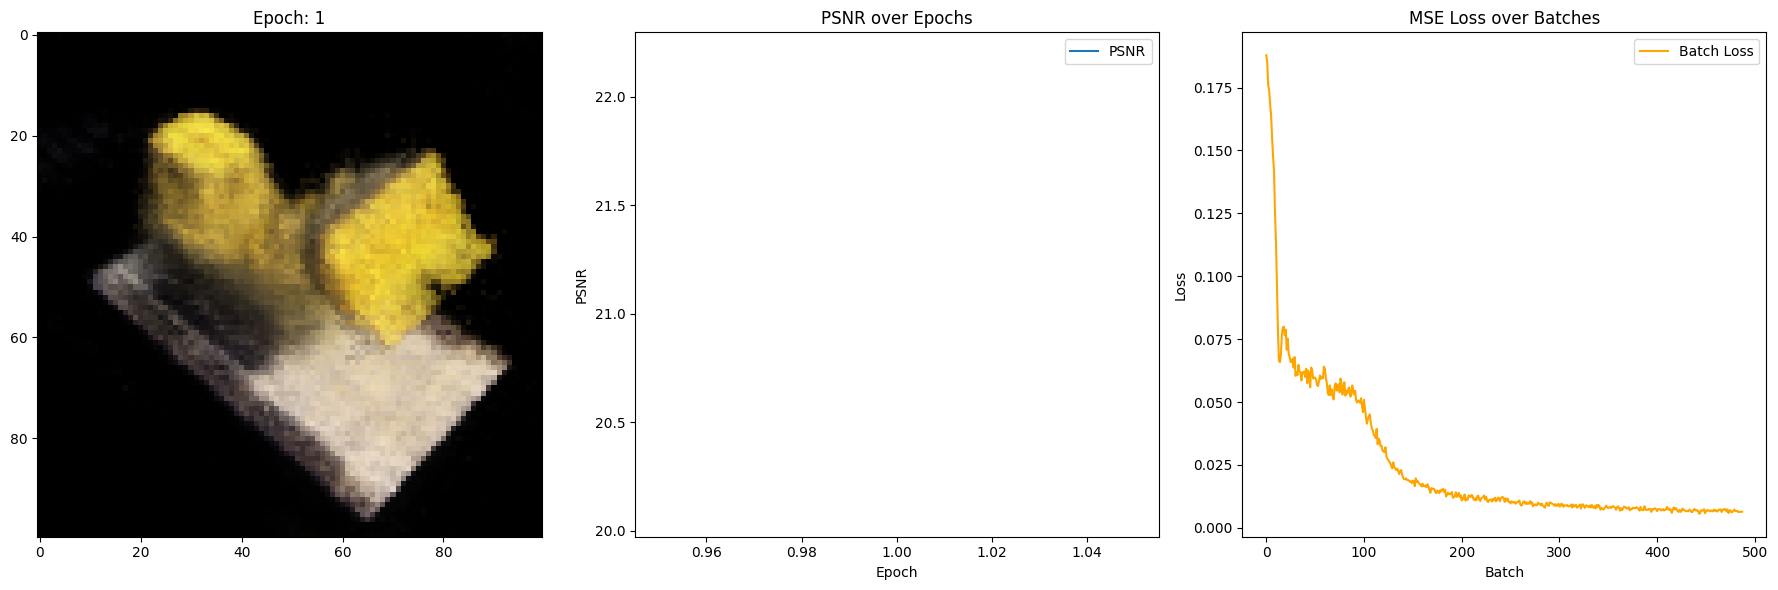

100%|██████████| 488/488 [01:16<00:00,  6.39it/s]


PSNR score=tensor([23.4886])
Average loss per epoch = 0.004828776928050382


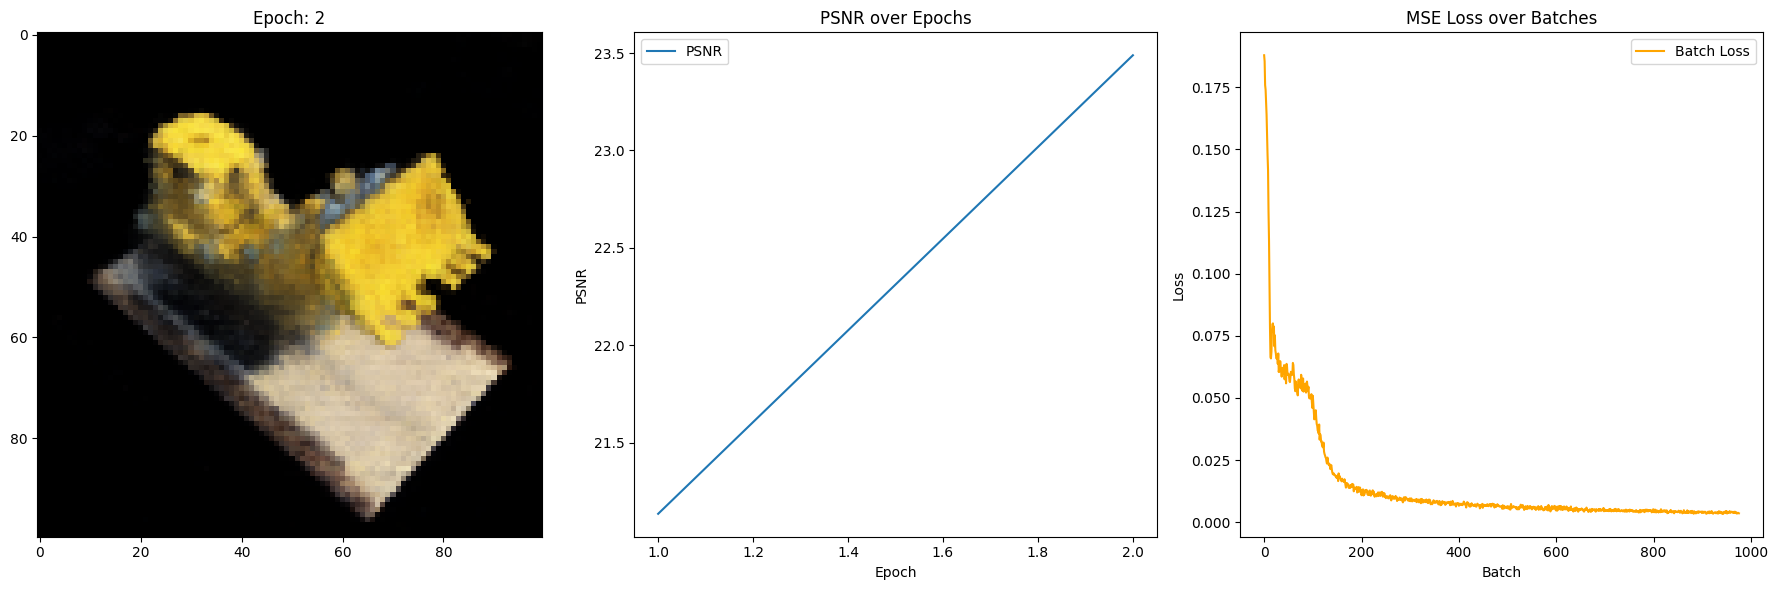

100%|██████████| 488/488 [01:17<00:00,  6.33it/s]


PSNR score=tensor([24.4642])
Average loss per epoch = 0.0031729676053653183


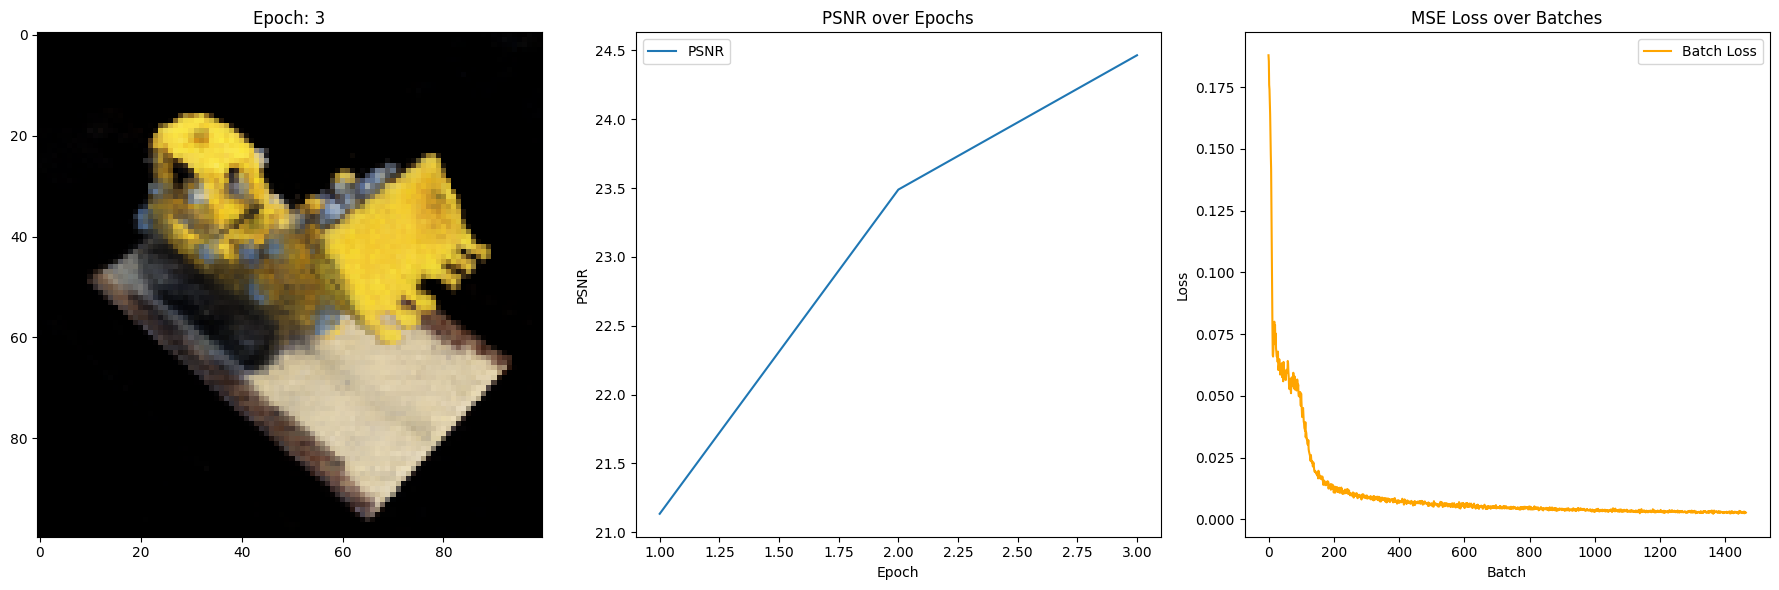

100%|██████████| 488/488 [01:16<00:00,  6.34it/s]


PSNR score=tensor([25.5547])
Average loss per epoch = 0.002406221258379595


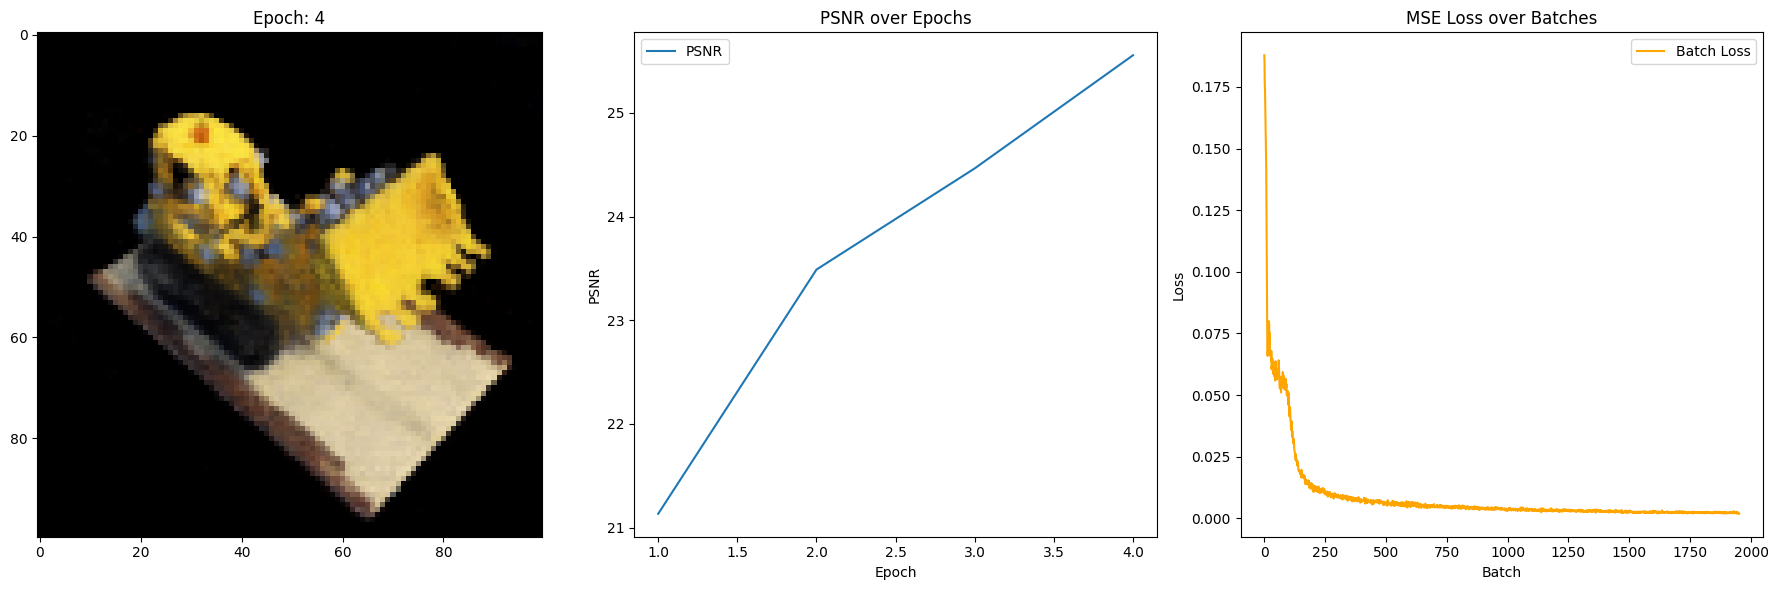

100%|██████████| 488/488 [01:16<00:00,  6.35it/s]


PSNR score=tensor([25.8207])
Average loss per epoch = 0.0020025956361424788


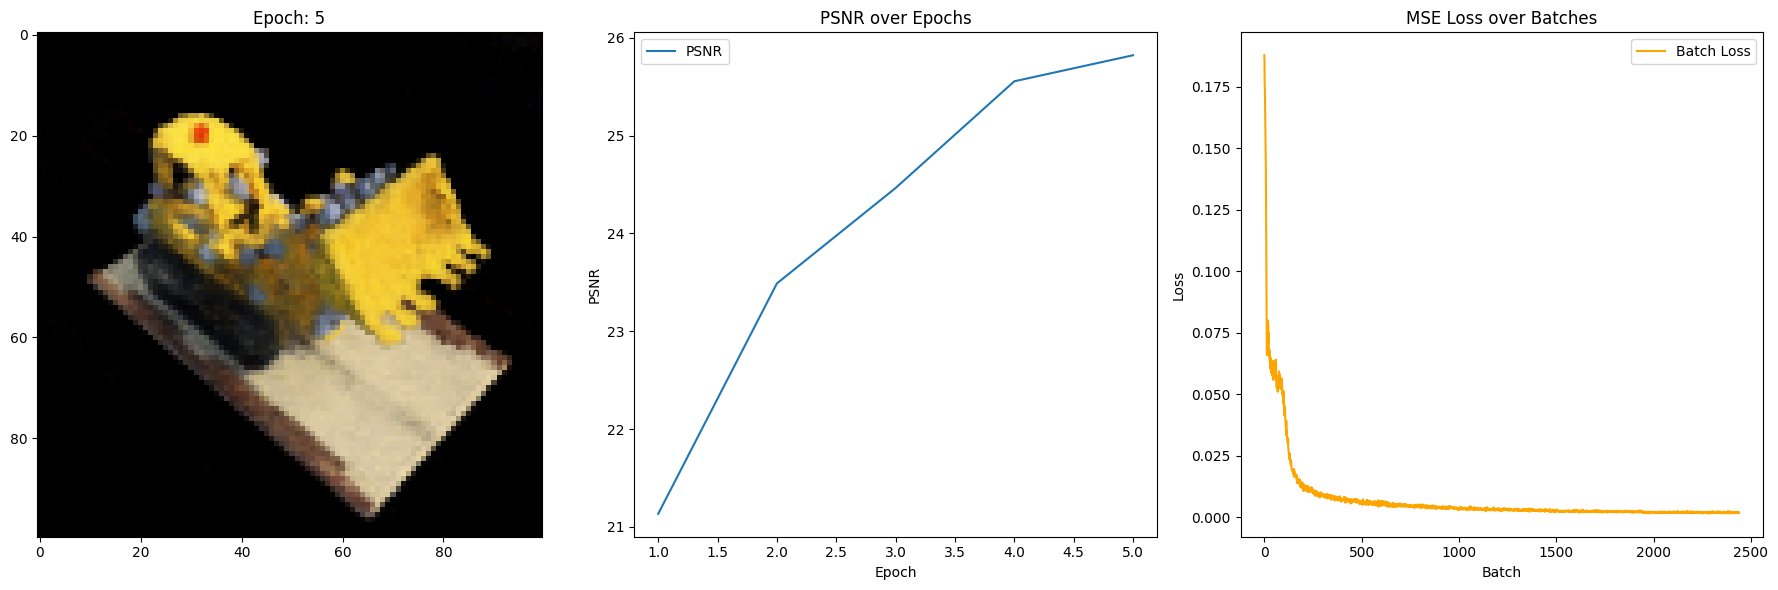

100%|██████████| 488/488 [01:17<00:00,  6.32it/s]


PSNR score=tensor([26.4179])
Average loss per epoch = 0.0017743330314320314


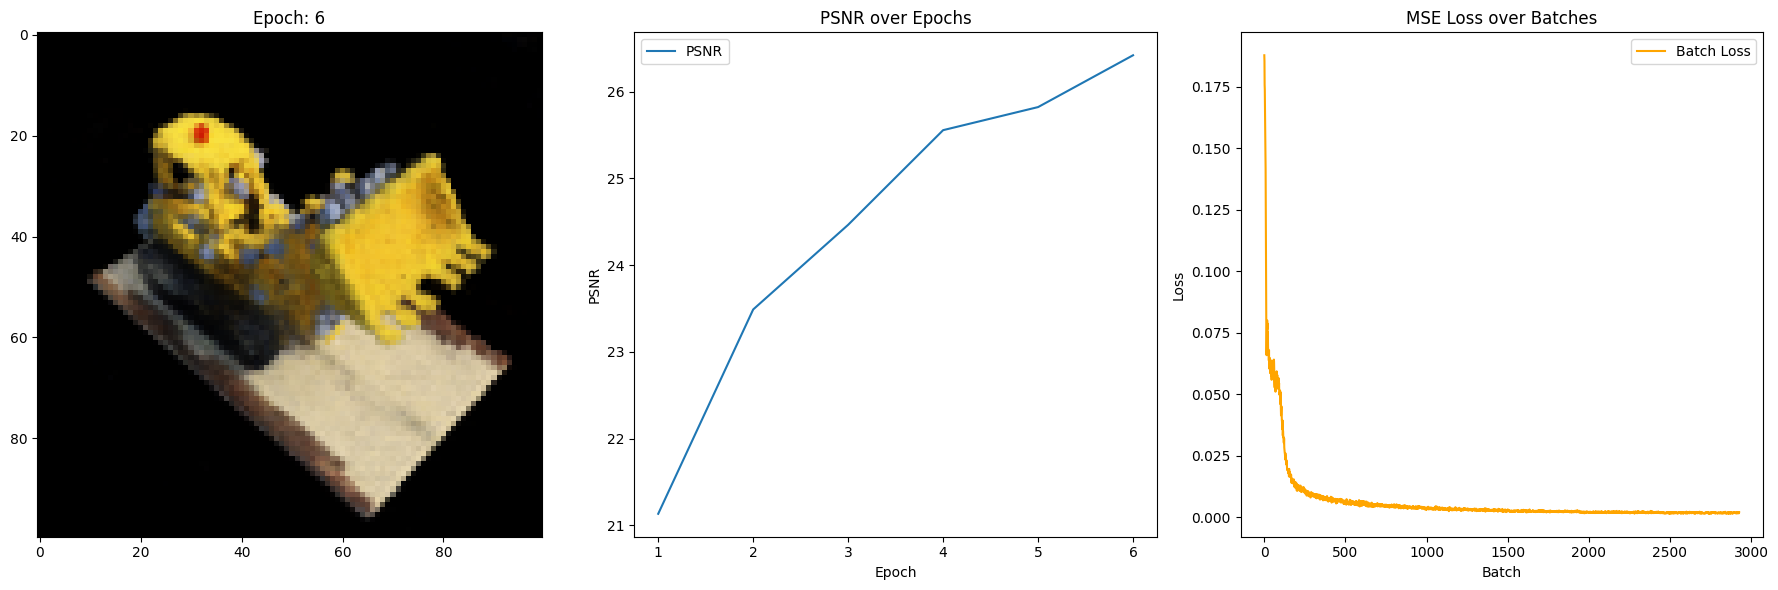

100%|██████████| 488/488 [01:16<00:00,  6.34it/s]


PSNR score=tensor([26.8207])
Average loss per epoch = 0.001611371074238273


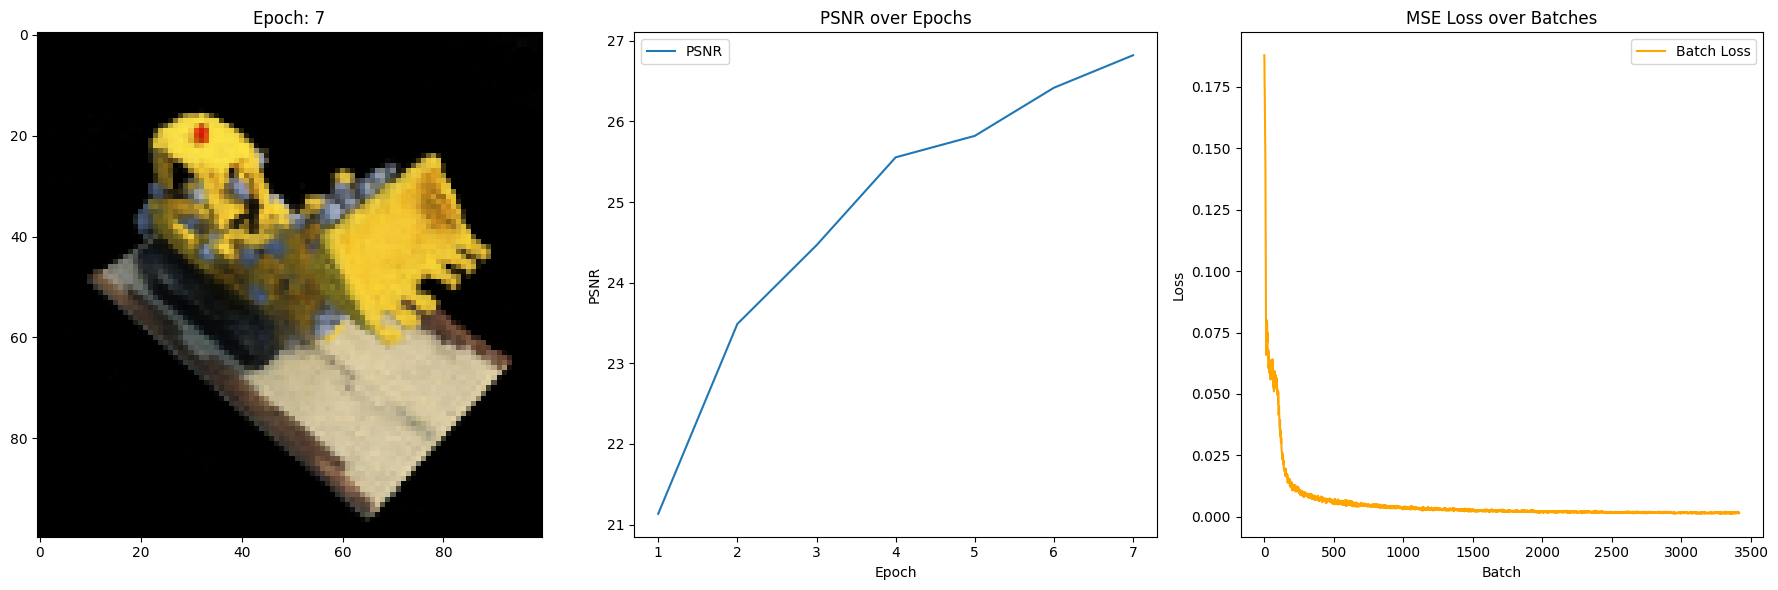

100%|██████████| 488/488 [01:17<00:00,  6.33it/s]


PSNR score=tensor([26.9659])
Average loss per epoch = 0.0015058258050274042


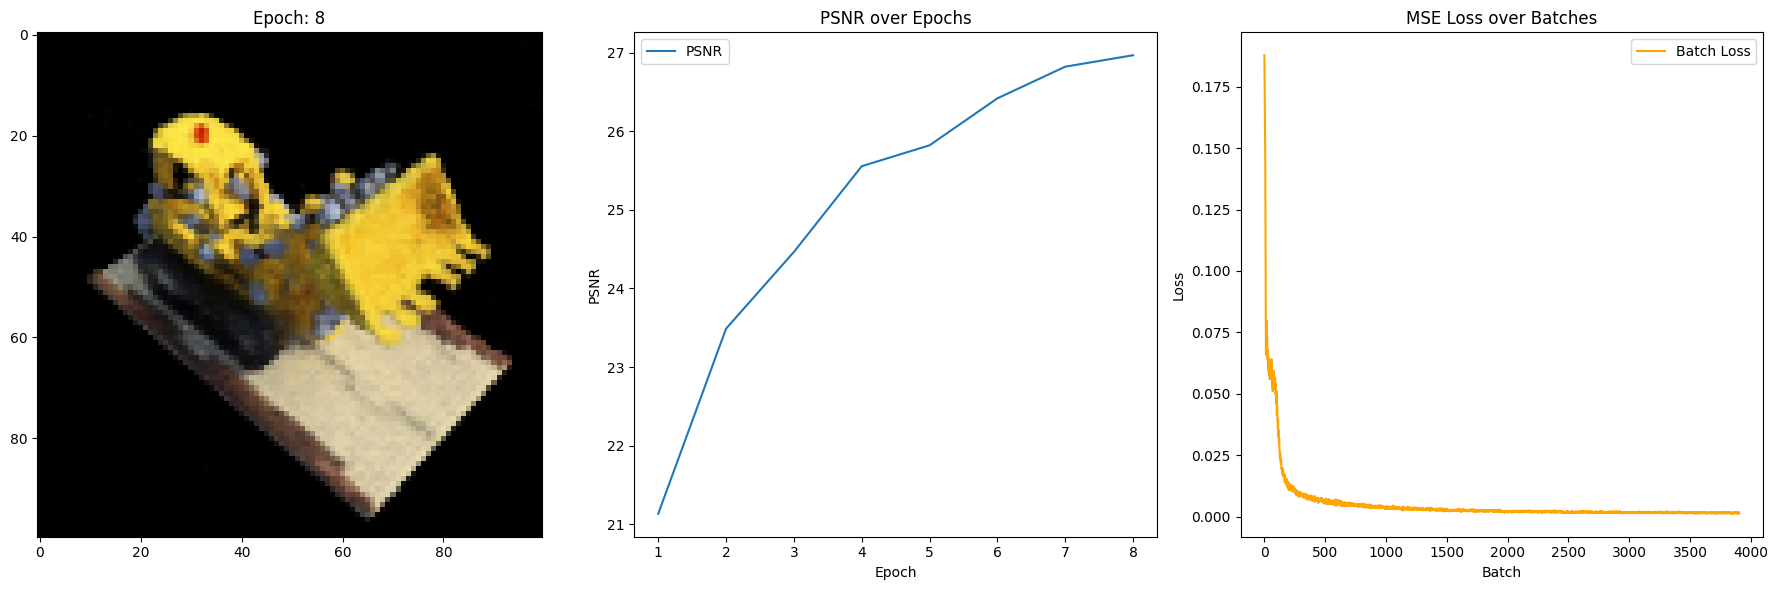

100%|██████████| 488/488 [01:17<00:00,  6.34it/s]


PSNR score=tensor([26.8987])
Average loss per epoch = 0.0014031499363749182


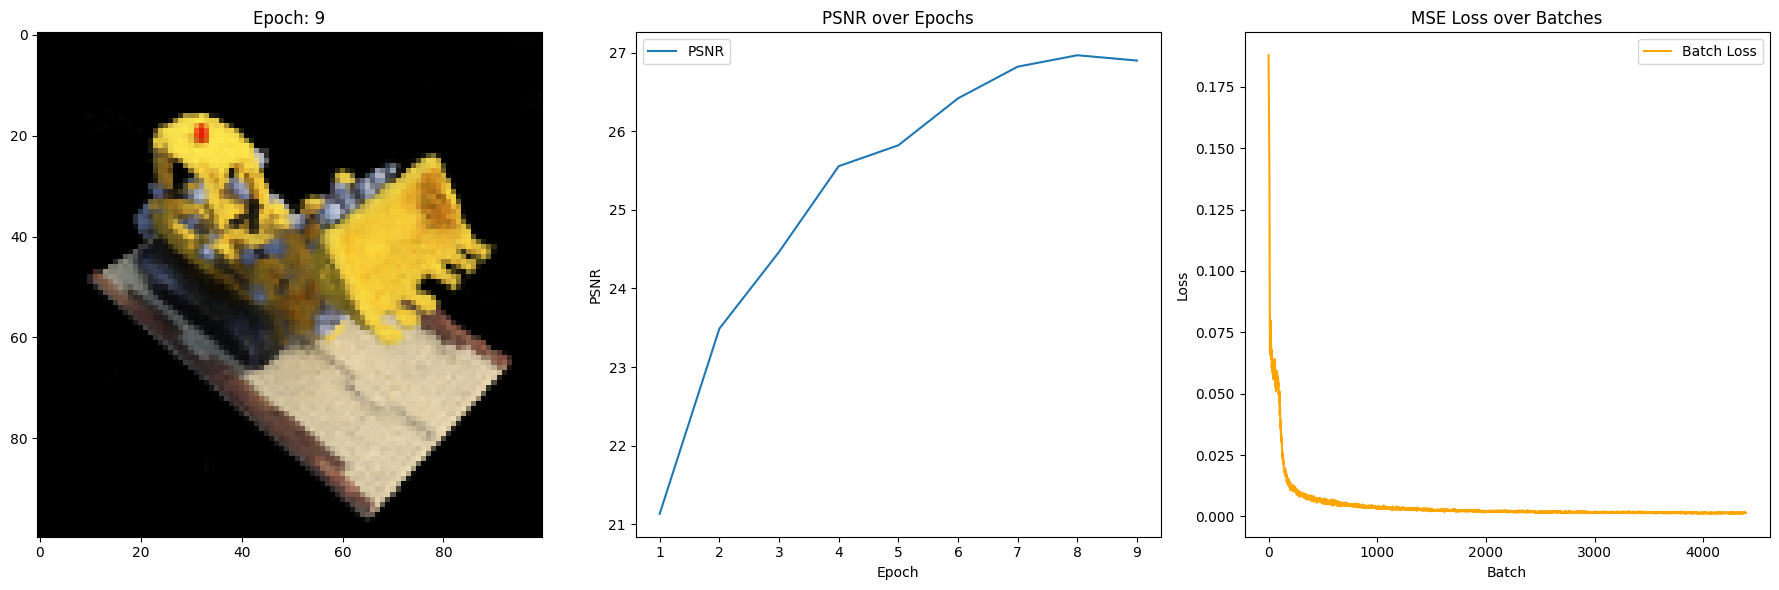

100%|██████████| 488/488 [01:17<00:00,  6.33it/s]


PSNR score=tensor([27.1556])
Average loss per epoch = 0.00131220226073504


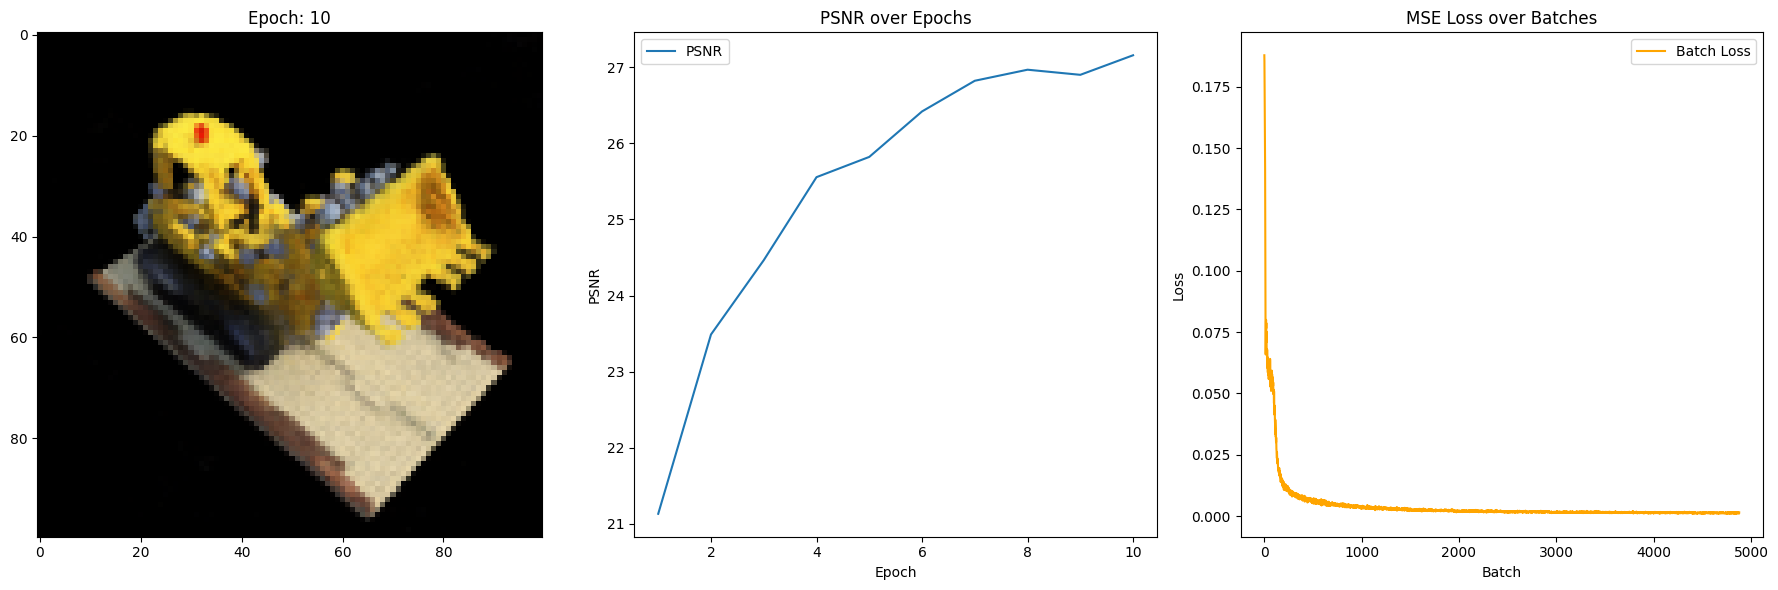

100%|██████████| 488/488 [01:16<00:00,  6.34it/s]


PSNR score=tensor([27.2391])
Average loss per epoch = 0.0012409996619919452


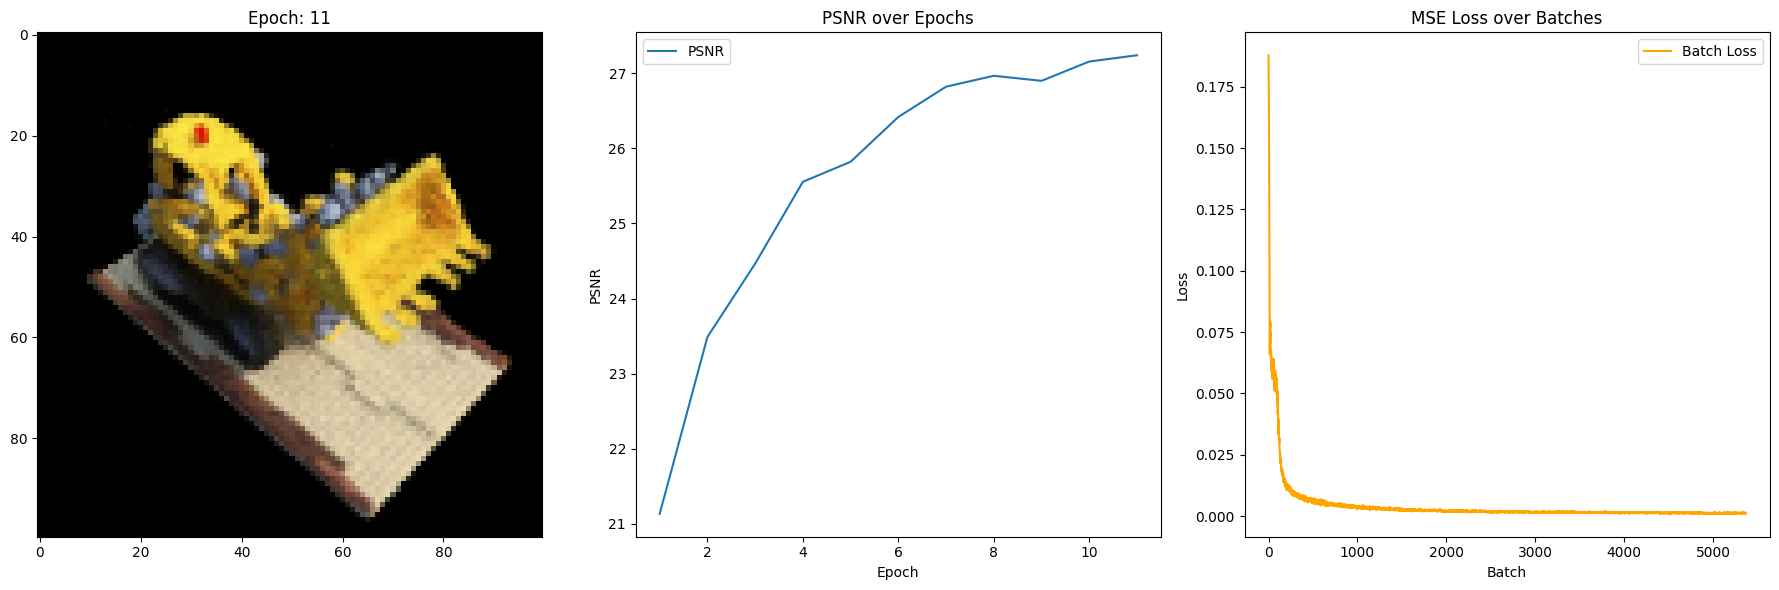

100%|██████████| 488/488 [01:16<00:00,  6.34it/s]


PSNR score=tensor([27.7485])
Average loss per epoch = 0.0011674184965248388


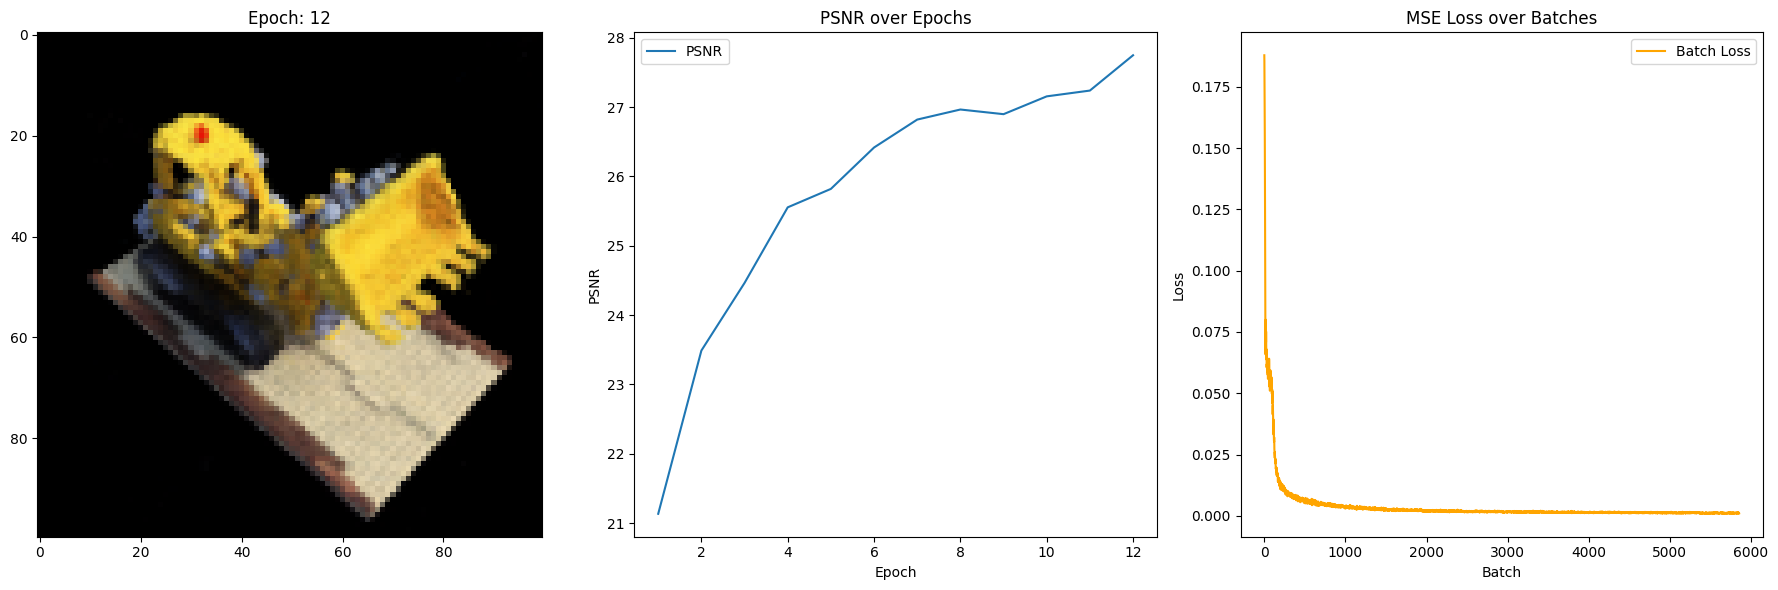

100%|██████████| 488/488 [01:17<00:00,  6.34it/s]


PSNR score=tensor([27.7198])
Average loss per epoch = 0.0011157811788477569


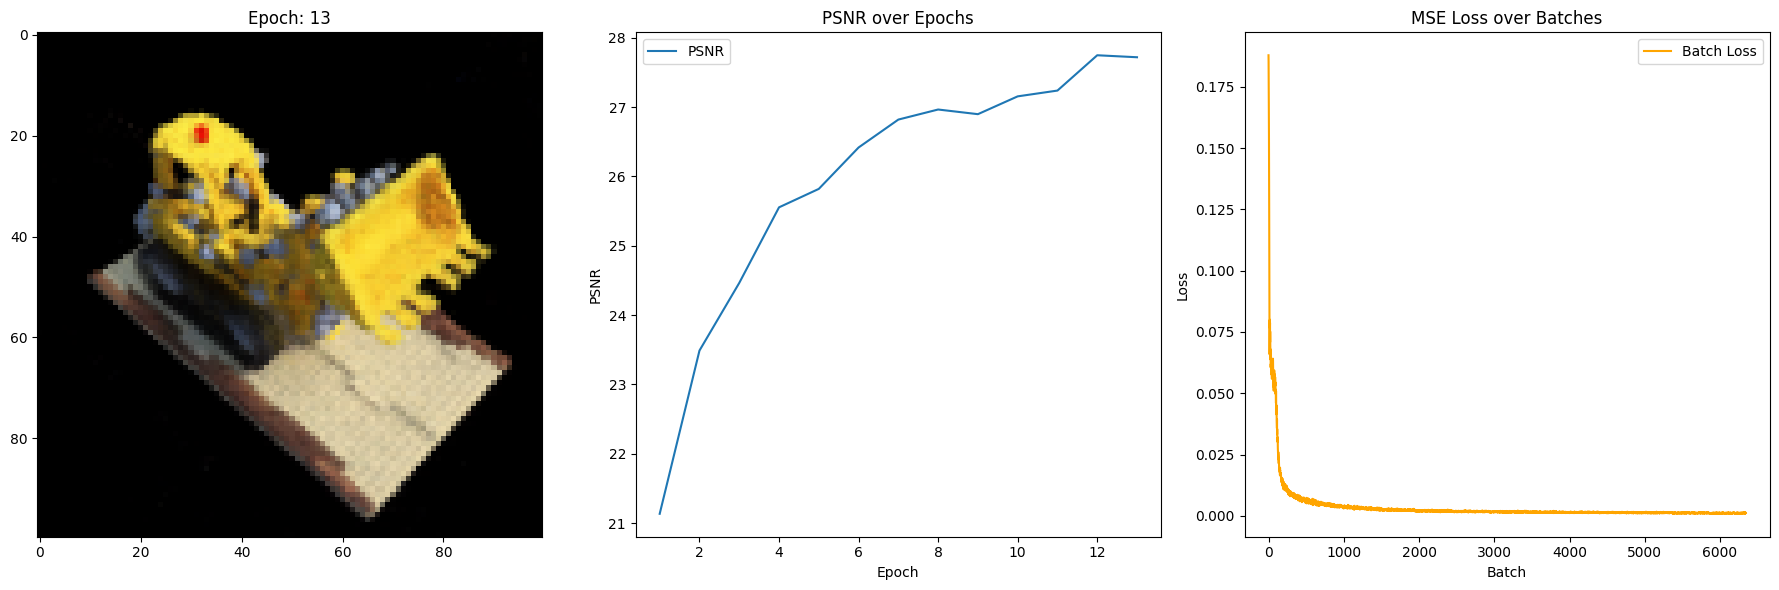

100%|██████████| 488/488 [01:17<00:00,  6.33it/s]


PSNR score=tensor([27.6715])
Average loss per epoch = 0.0010685217181520277


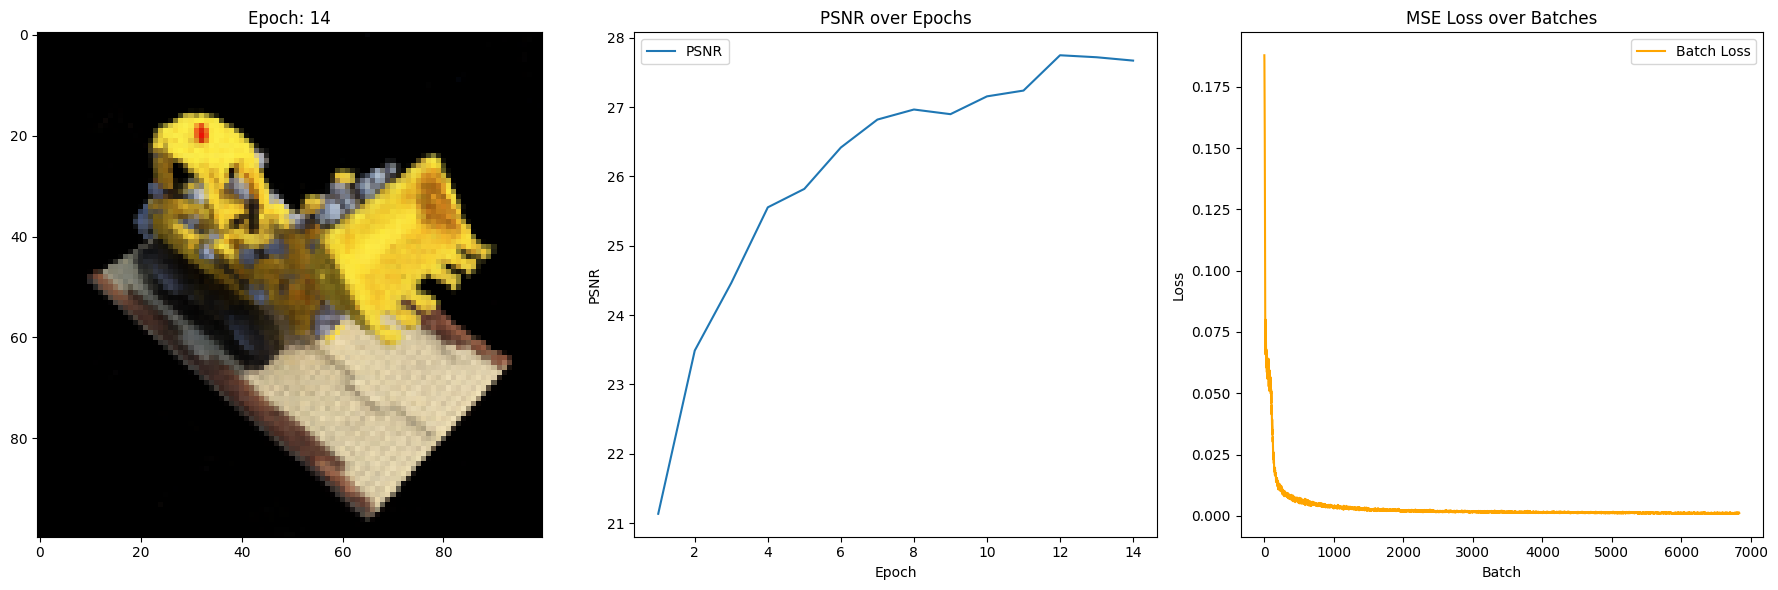

100%|██████████| 488/488 [01:17<00:00,  6.32it/s]


PSNR score=tensor([28.3401])
Average loss per epoch = 0.001017263454845992


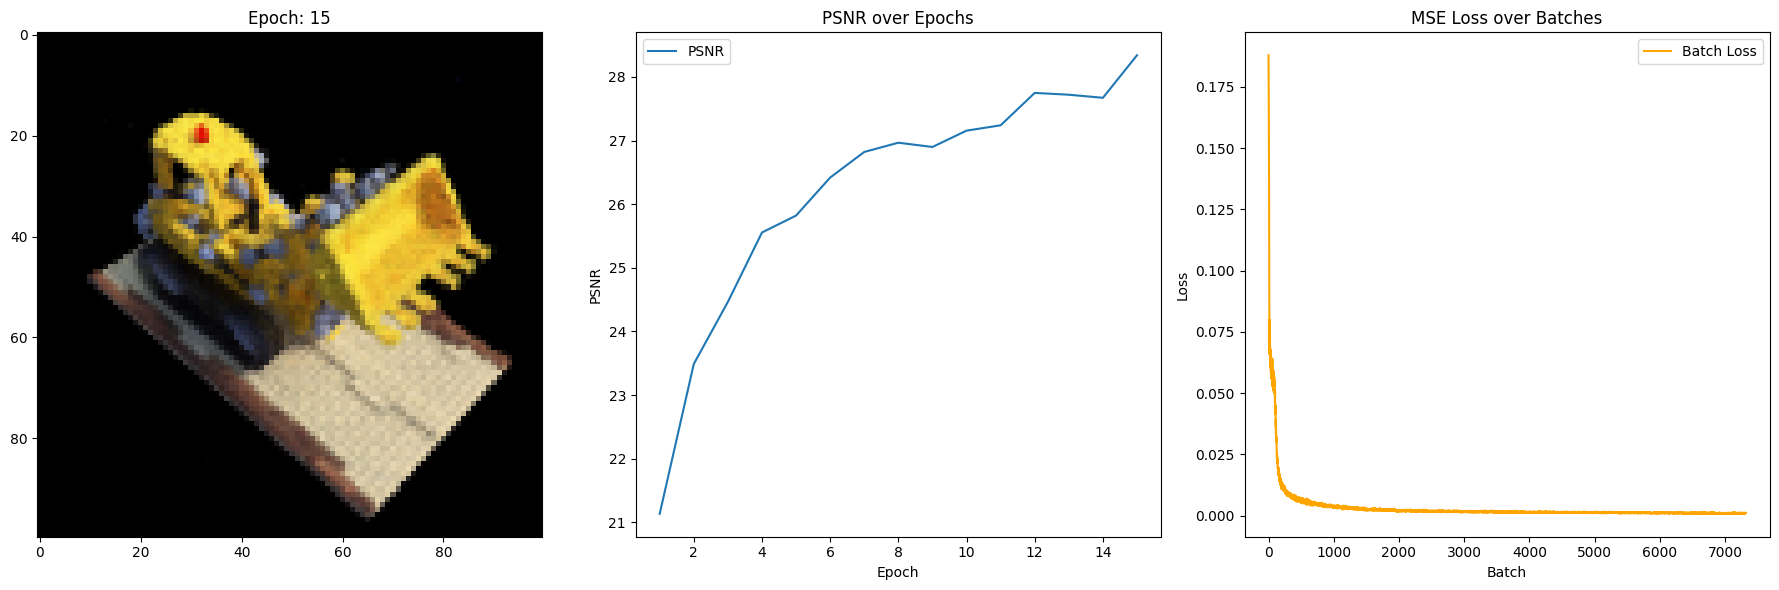

100%|██████████| 488/488 [01:17<00:00,  6.30it/s]


PSNR score=tensor([27.8434])
Average loss per epoch = 0.0009948690194058324


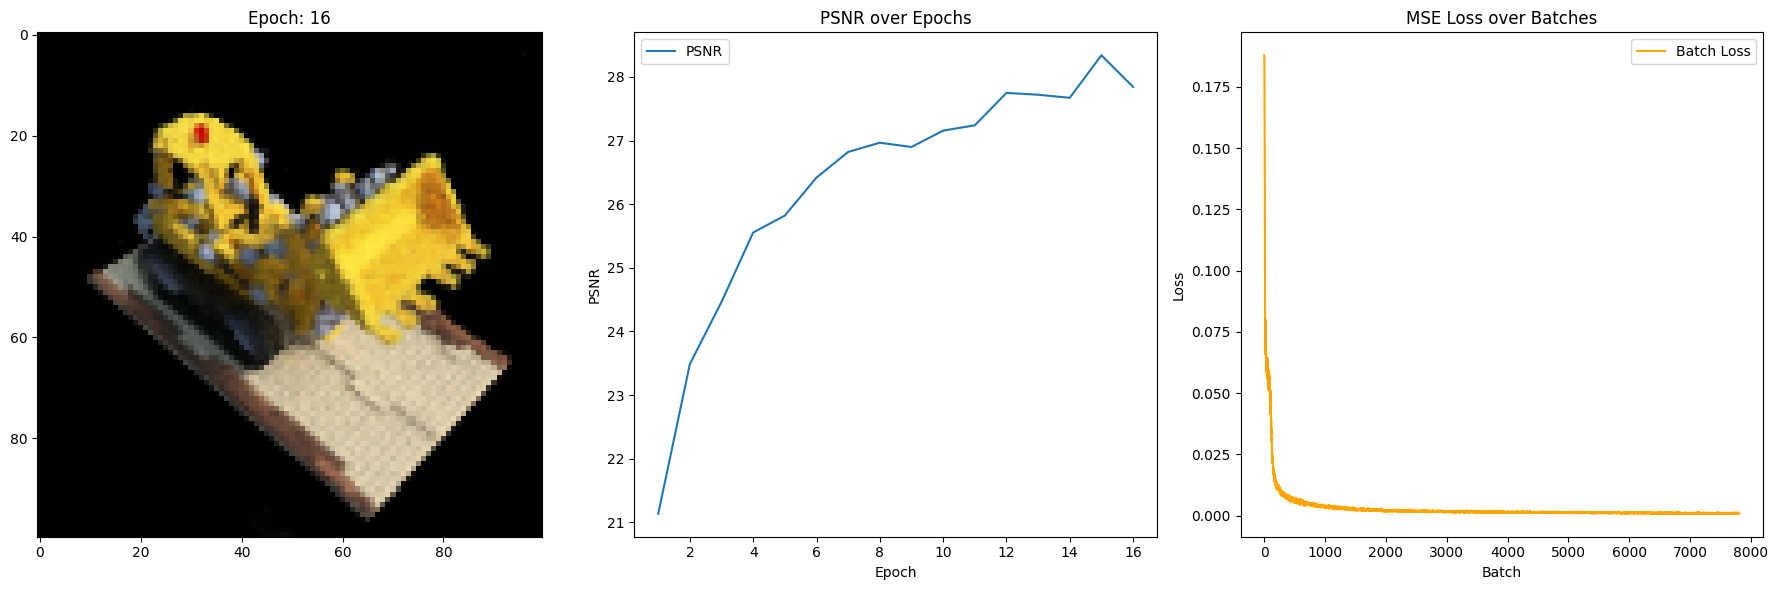

100%|██████████| 488/488 [01:17<00:00,  6.32it/s]


PSNR score=tensor([28.3958])
Average loss per epoch = 0.000954412970311184


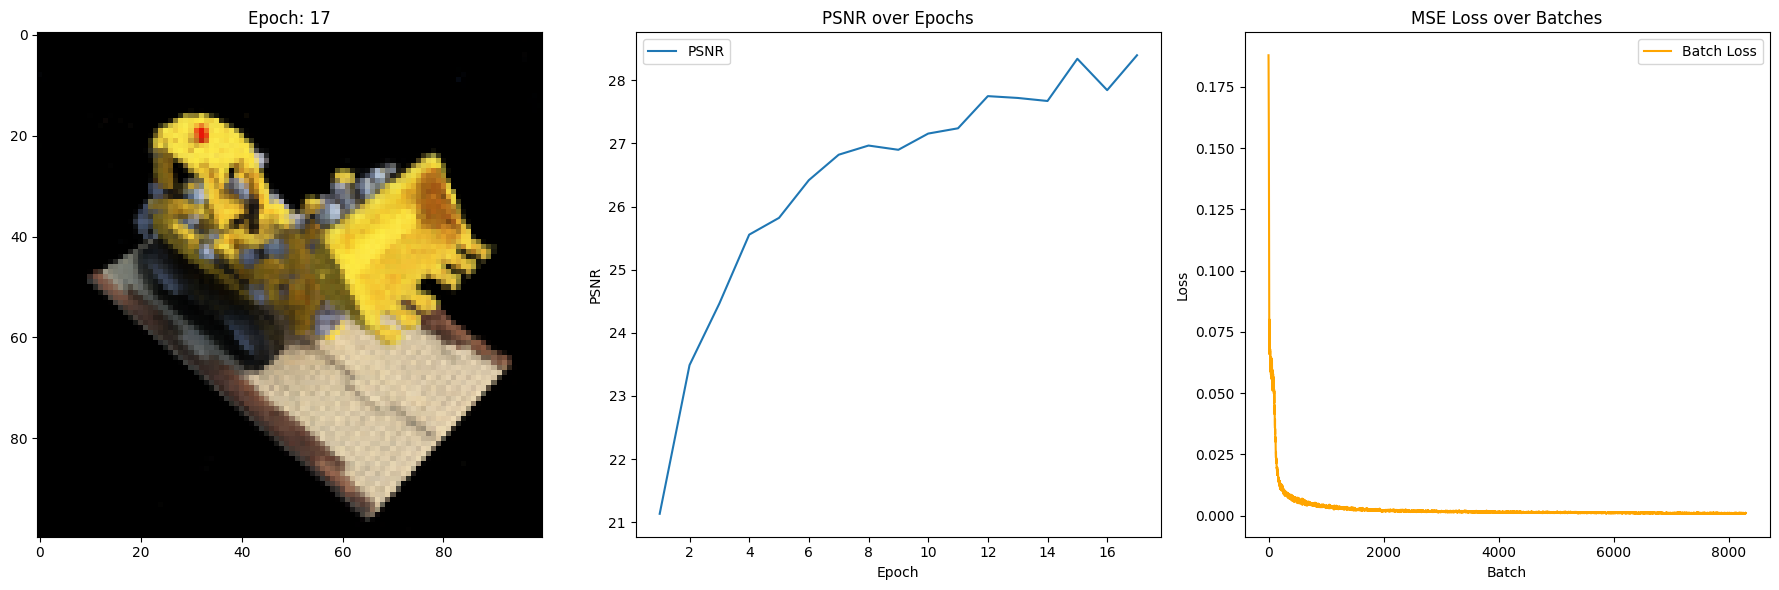

100%|██████████| 488/488 [01:17<00:00,  6.32it/s]


PSNR score=tensor([28.3786])
Average loss per epoch = 0.0009146351989866311


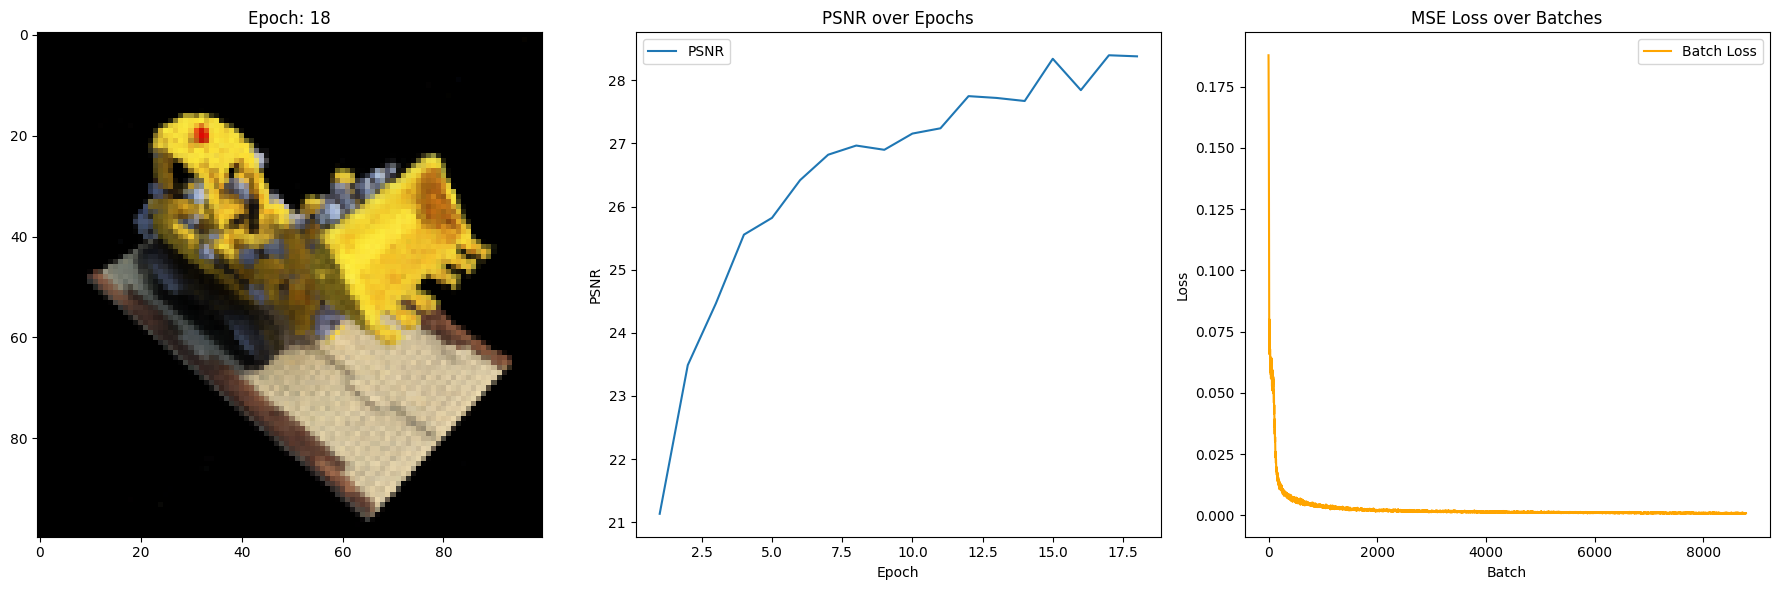

100%|██████████| 488/488 [01:17<00:00,  6.32it/s]


PSNR score=tensor([28.3527])
Average loss per epoch = 0.0008767944873696132


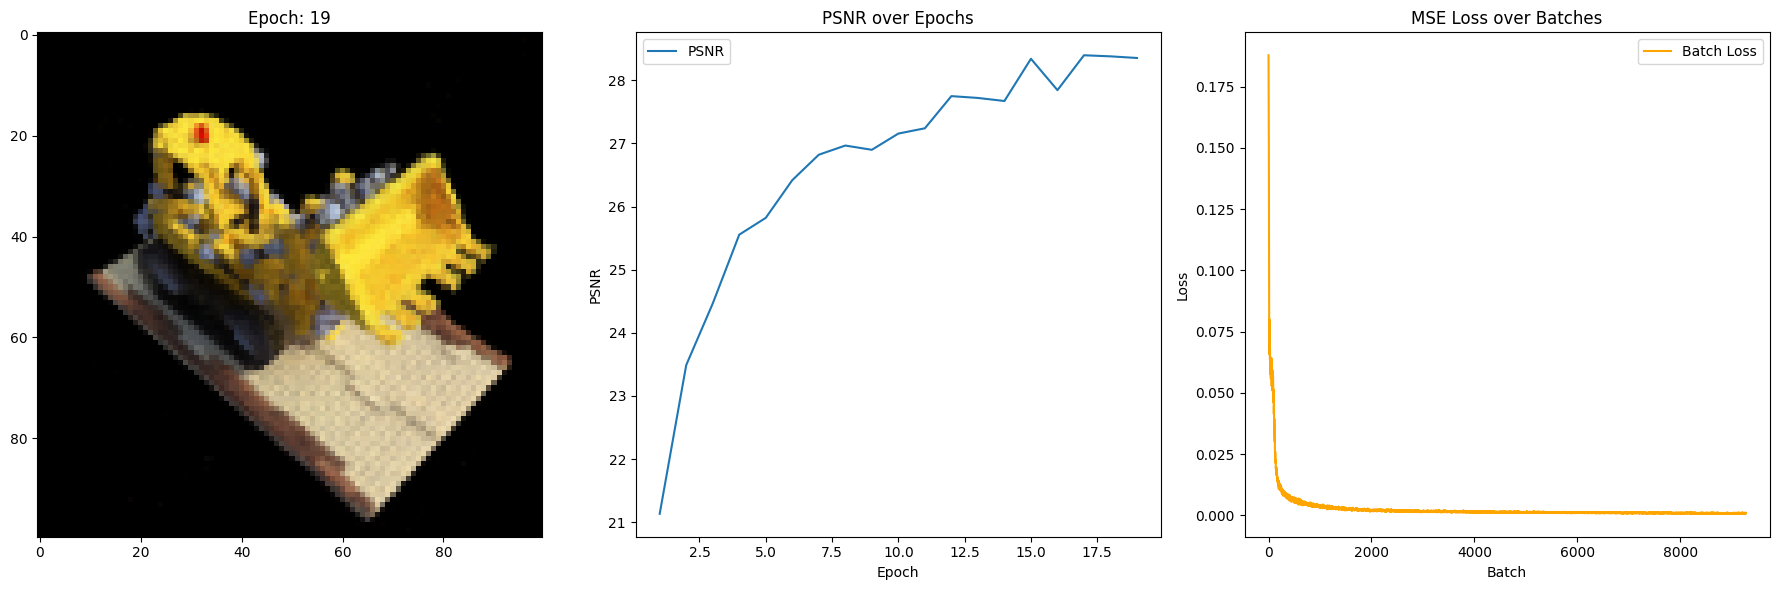

100%|██████████| 488/488 [01:16<00:00,  6.36it/s]


PSNR score=tensor([28.3253])
Average loss per epoch = 0.0008589641976391621


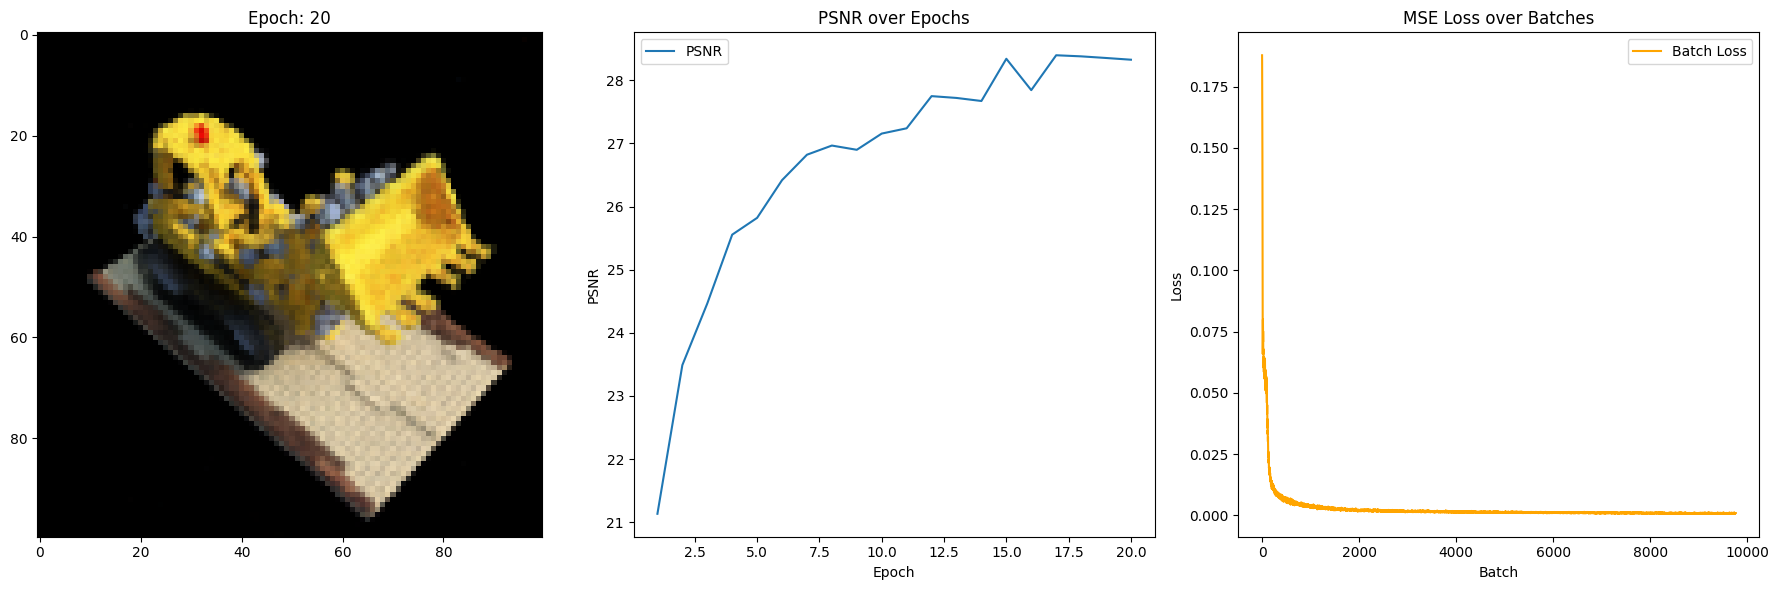

In [10]:

# Sample rays for all images
sampled_rays = [
    sample_rays_numpy(height, width, focal_length, pose_data[img_idx])
    for img_idx in range(num_training_images)
]

# Unpack sampled rays
ray_origins_list, ray_directions_list = zip(*sampled_rays)

# Reshape rays and images
ray_origins_list = [orig.reshape(-1, 3) for orig in ray_origins_list]
ray_directions_list = [dir.reshape(-1, 3) for dir in ray_directions_list]
list_rays = [image_data[img_idx].reshape(-1, 3) for img_idx in range(num_training_images)]

# Convert lists to numpy arrays and stack them vertically
ray_origins_array = np_lib.vstack(ray_origins_list)
ray_directions_array = np_lib.vstack(ray_directions_list)
ray_rgb_array = np_lib.vstack(list_rays)

# Verify the shapes to ensure correctness (optional debugging step)
assert ray_origins_array.shape[0] == ray_directions_array.shape[0] == ray_rgb_array.shape[0], "Mismatch in number of rays"

# Combine all ray components into a single numpy array
rays_combined_array = np_lib.hstack([ray_origins_array, ray_directions_array, ray_rgb_array])

# Convert the combined numpy array to a PyTorch tensor
rays = torch_lib.tensor(rays_combined_array, device=computation_device)

# parameters of training

batch_size = 2048
num_total_rays = rays.shape[0]
print(f"The number of batches is {num_total_rays // batch_size} and each batch has {batch_size} rays")


num_epochs = 20
psnr_history = []
epoch_indices = []
depth_bounds = (2.0, 6.0)
sample_counts = (64, None)
directions_use_view = True

# Sample rays for the test image
test_ray_origins, test_ray_directions = sample_rays_numpy(height, width, focal_length, test_pose)

# Create a dictionary to store the test data
test_data = {
    'ray_origins': test_ray_origins,
    'ray_directions': test_ray_directions,
    'rgb': test_image
}

# Convert all test data to PyTorch tensors and store them back in the dictionary
test_data_tensors = {key: torch_lib.tensor(value, device=computation_device) for key, value in test_data.items()}

# Extract the tensors from the dictionary
test_ray_origins_tensor = test_data_tensors['ray_origins']
test_ray_directions_tensor = test_data_tensors['ray_directions']
test_rgb_tensor = test_data_tensors['rgb']

# train

nerf_model = NeuralRadianceField(directions_use_view=directions_use_view).to(computation_device)
optimizer_adm = optim_lib.Adam(nerf_model.parameters(), lr=5e-4)
mean_squared_error = nn_lib.MSELoss()

num_batches = num_total_rays // batch_size
epoch_indices = []
psnr_history = []
batch_loss_history = []

for epoch in range(num_epochs):
    # Randomly permute the order of rays
    random_indices = torch_lib.randperm(num_total_rays)
    permuted_rays = rays[random_indices, :]

    # Split permuted rays into batches for training
    training_batches = iter(torch_lib.chunk(permuted_rays, int(num_total_rays / batch_size), dim=0))

    epoch_loss = 0

    for batch_index in progress_lib(range(num_batches)):
        batch_rays = next(training_batches)

        trial_dim = -1
        ray_origins_batch, ray_directions_batch, target_rgb_batch = torch_lib.chunk(batch_rays, 3, dim=trial_dim)
        batch_ray_origins_directions = (ray_origins_batch, ray_directions_batch)
        predicted_rgb, _, __ = rendering(nerf_model, batch_ray_origins_directions, bounds=depth_bounds, num_samples=sample_counts, comp_device=computation_device, directions_use_view=directions_use_view)
        losses = mean_squared_error(predicted_rgb, target_rgb_batch)
        optimizer_adm.zero_grad()

        losses.backward()

        optimizer_adm.step()

        epoch_loss += losses.item()
        batch_loss_history.append(losses.item())  # Collecting batch loss

    # Average loss over all batches in the epoch
    epoch_loss /= num_batches

    with torch_lib.no_grad():
        pred_rgb = []
        test_shape = test_ray_origins_tensor.shape[0]
        for ray_index in range(test_shape):
            # Extract the origin and direction for the test ray at the specified index and combine them using zip
            test_ray_data = next(zip(
                test_ray_origins_tensor[ray_index].unsqueeze(0),
                test_ray_directions_tensor[ray_index].unsqueeze(0)
            ))

            # Flatten the tuple
            ray_origins_directions_test = tuple(test_ray_data)

            predicted_rgb, _, __ = rendering(nerf_model, ray_origins_directions_test, bounds=depth_bounds, num_samples=sample_counts, comp_device=computation_device, directions_use_view=directions_use_view)

            fix_rgb_pred = predicted_rgb.unsqueeze(0)

            pred_rgb.append(fix_rgb_pred)

        predicted_rgb_tensor = torch_lib.cat(pred_rgb, dim=0)
        test_loss = mean_squared_error(predicted_rgb_tensor, test_rgb_tensor).cpu()
        psnr_value = -10.0 * torch_lib.log(test_loss).item() / torch_lib.log(torch_lib.tensor([10.0]))
        print(f"PSNR score={psnr_value}")
        print(f"Average loss per epoch = {epoch_loss}")

        epoch_step = epoch + 1
        epoch_indices.append(epoch_step)
        psnr_history.append(psnr_value)

        # Plot PSNR, Training Loss, and Batch Loss
        plot_lib.figure(figsize=(18, 6))

        # Plot predicted RGB
        plot_lib.subplot(131)
        var_pred = predicted_rgb_tensor.cpu().detach()
        plot_lib.imshow(var_pred.numpy())
        plot_lib.title(f'Epoch: {epoch_step}')

        # Plot PSNR
        plot_lib.subplot(132)
        plot_lib.plot(epoch_indices, psnr_history, label='PSNR')
        plot_lib.xlabel('Epoch')
        plot_lib.ylabel('PSNR')
        plot_lib.title('PSNR over Epochs')
        plot_lib.legend()

        # Plot Batch Loss
        plot_lib.subplot(133)
        plot_lib.plot(batch_loss_history, label='Batch Loss', color='orange')
        plot_lib.xlabel('Batch')
        plot_lib.ylabel('Loss')
        plot_lib.title('MSE Loss over Batches')
        plot_lib.legend()

        plot_lib.tight_layout()
        plot_lib.show()


In [11]:
import numpy as np_lib
import torch as torch_lib
from tqdm import tqdm as progress_lib
import imageio as imageio_lib

rendered_frames = []
pred_rgb = []
for theta_angle in progress_lib(np_lib.linspace(0.0, 360.0, 120, endpoint=False)):
    with torch_lib.no_grad():
        camera_to_world_matrix = calculate_camera_pose(theta_angle, -30.0, 4.0)
        ray_origins, ray_directions = sample_rays_numpy(height, width, focal_length, camera_to_world_matrix[:3, :4])

        for ray_index in range(ray_origins.shape[0]):
            ray_origins_directions_test = (T.tensor(ray_origins[ray_index], dtype=T.float32).to(computation_device),T.tensor(ray_directions[ray_index], dtype=T.float32).to(computation_device))

            rgb_output, depth_output, acc_output = rendering(
                nerf_model, ray_origins_directions_test, bounds=depth_bounds, num_samples=sample_counts, comp_device=computation_device, directions_use_view=directions_use_view
            )

            rgb_output = rgb_output.unsqueeze(0)

            pred_rgb.append(rgb_output)
    predicted_rgb_tensor = torch_lib.cat(pred_rgb, dim=0)
    rendered_frames.append((255 * np_lib.clip(predicted_rgb_tensor.cpu().numpy(), 0, 1)).astype(np_lib.uint8))
    pred_rgb=[]

video_filename = 'rendered_video.mp4'
imageio_lib.mimwrite(video_filename, rendered_frames, fps=20, quality=10)


100%|██████████| 120/120 [00:41<00:00,  2.91it/s]


In [12]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('rendered_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)